In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import sqlite3
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import confusion_matrix
from pandas import read_csv

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)

rcParams['figure.figsize'] = 22,10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
con = sqlite3.connect("../Datos/Database/ProyectoFinal.db")

In [3]:
df = pd.read_sql_query("Select Fecha, sum(Existencias) TotalExistencias from Movimientos where FamiliaDesc NOT IN ('COMBUSTIBLES','ADITIVOS PARA LA COMBUSTION','LUBRICANTES','LÍQUIDOS REFRIGERANTES','CASCOS (NO INVENTARIABLE)','UTILES DE PERSONAL','UNIFORMES') AND Fecha > '2008-01-01' AND ArticuloDesc NOT IN ('no existe viene mal de PICK','PASTA MANOS',' ...........  no usar ...............', '..', 'PASTA MANOS ZORKIL-C35') AND FamiliaDesc = 'BOMBILLOS Y LAMPARAS' AND ArticuloDesc = 'BOMBILLO 24V-5W ZEPELIN (N109)7552' group by Fecha",con,parse_dates=['Fecha'],index_col='Fecha')

In [4]:
df2 =  read_csv('PredicciónMovimientosBombillas.csv', parse_dates=['Fecha'],index_col='Fecha') #Tiene cantidades aleatorias
                                                                                    #No se usan después para la predicción!!!!
                                                                                    #Se borran
                                                                                    #Lo dejé asi por pereza

### Primero análisis exploratorio

In [5]:
df.head()

TotalExistencias
Fecha                       
2008-01-02             186.0
2008-01-03             241.0
2008-01-04             389.0
2008-01-05              48.0
2008-01-08             469.0

In [6]:
df['Dia de la semana'] = df.index.dayofweek
df['Dia del mes'] = df.index.day
df['Mes'] = df.index.month

In [7]:
df2['Dia de la semana'] = df2.index.dayofweek
df2['Dia del mes'] = df2.index.day
df2['Mes'] = df2.index.month

In [8]:
df.head()

TotalExistencias  Dia de la semana  Dia del mes  Mes
Fecha                                                           
2008-01-02             186.0                 2            2    1
2008-01-03             241.0                 3            3    1
2008-01-04             389.0                 4            4    1
2008-01-05              48.0                 5            5    1
2008-01-08             469.0                 1            8    1

In [9]:
df.tail()

TotalExistencias  Dia de la semana  Dia del mes  Mes
Fecha                                                           
2020-05-19             205.0                 1           19    5
2020-05-21             138.0                 3           21    5
2020-05-25             177.0                 0           25    5
2020-05-26              87.0                 1           26    5
2020-05-27              56.0                 2           27    5

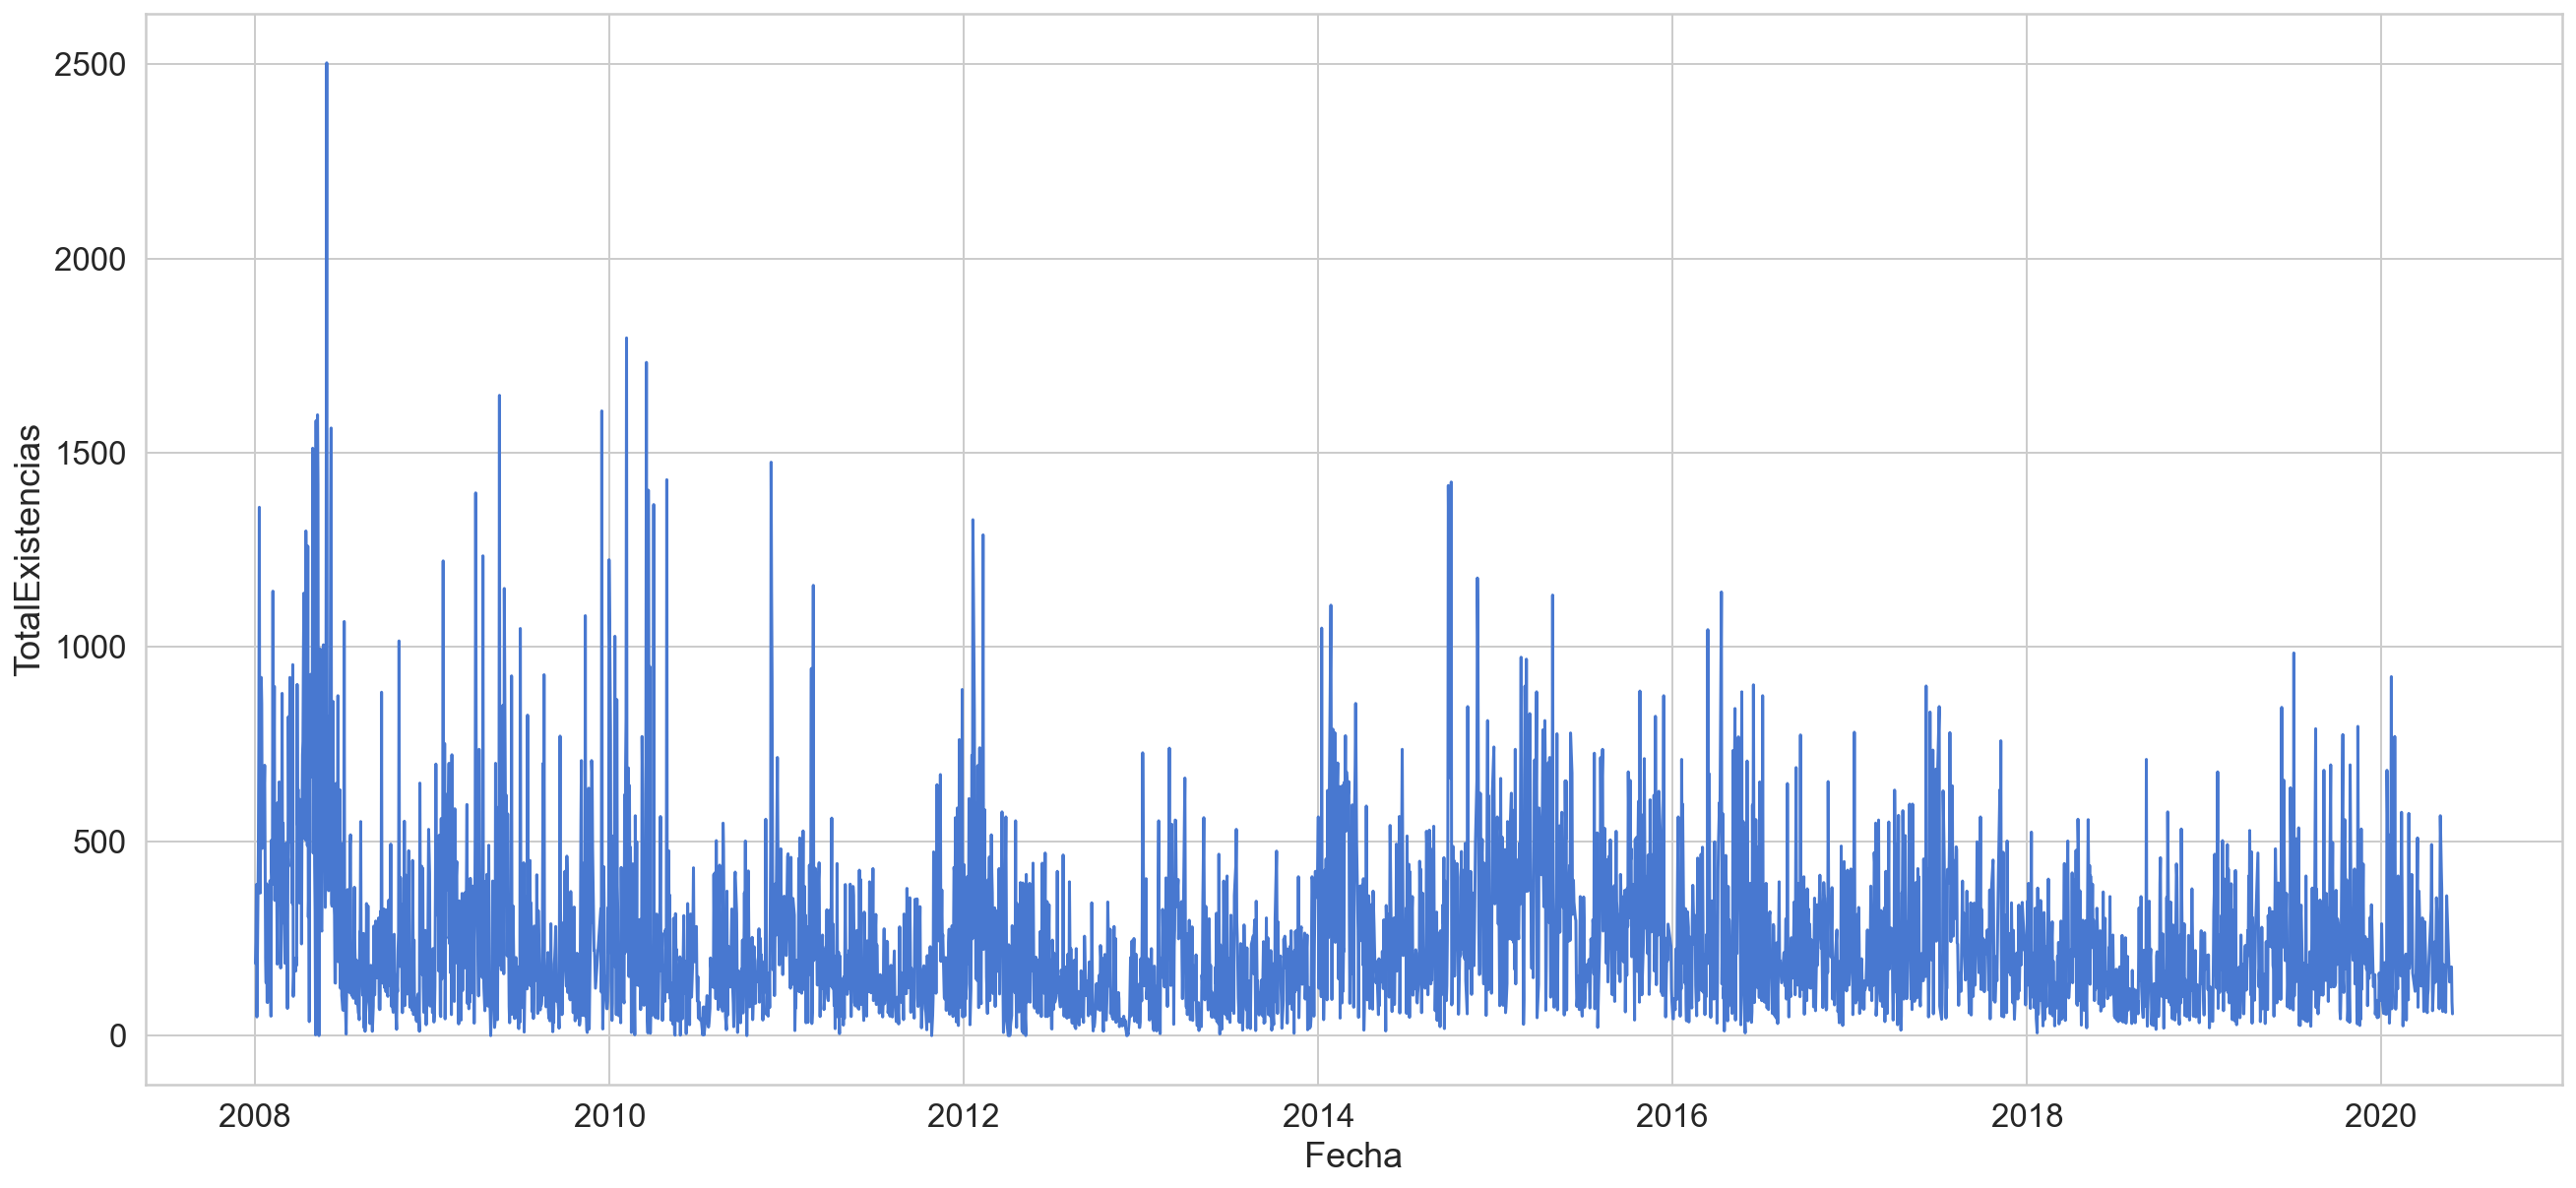

In [10]:
sns.lineplot(x=df.index, y='TotalExistencias', data=df)

### Aquí podemos ver si hay estacionalidad

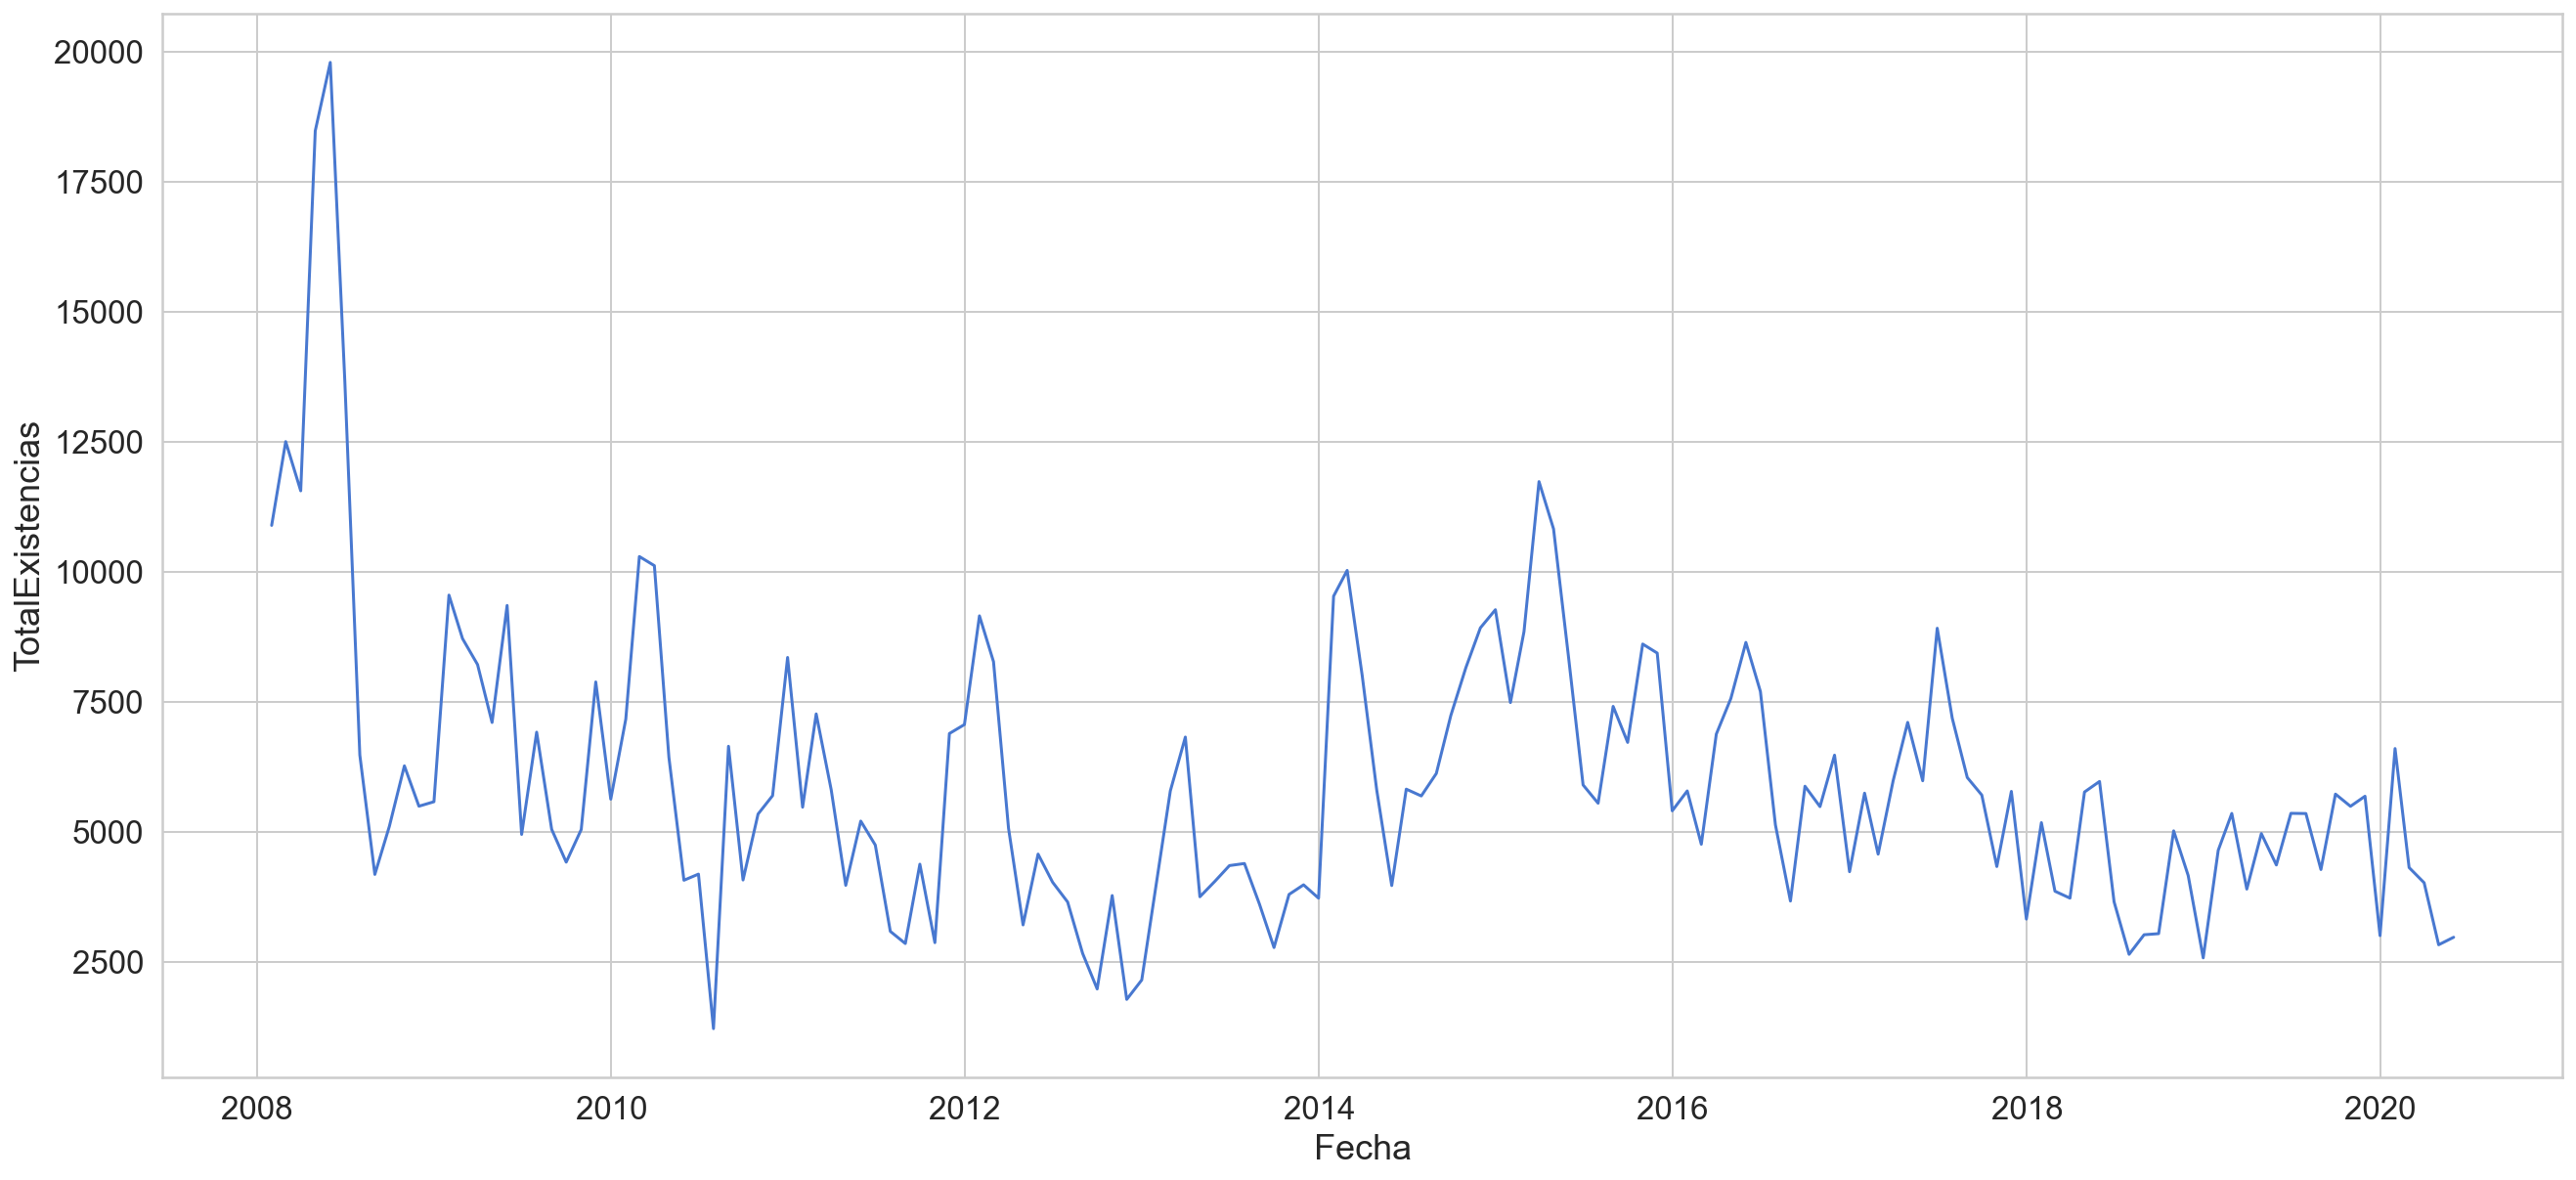

In [11]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y='TotalExistencias',data=df_by_month)

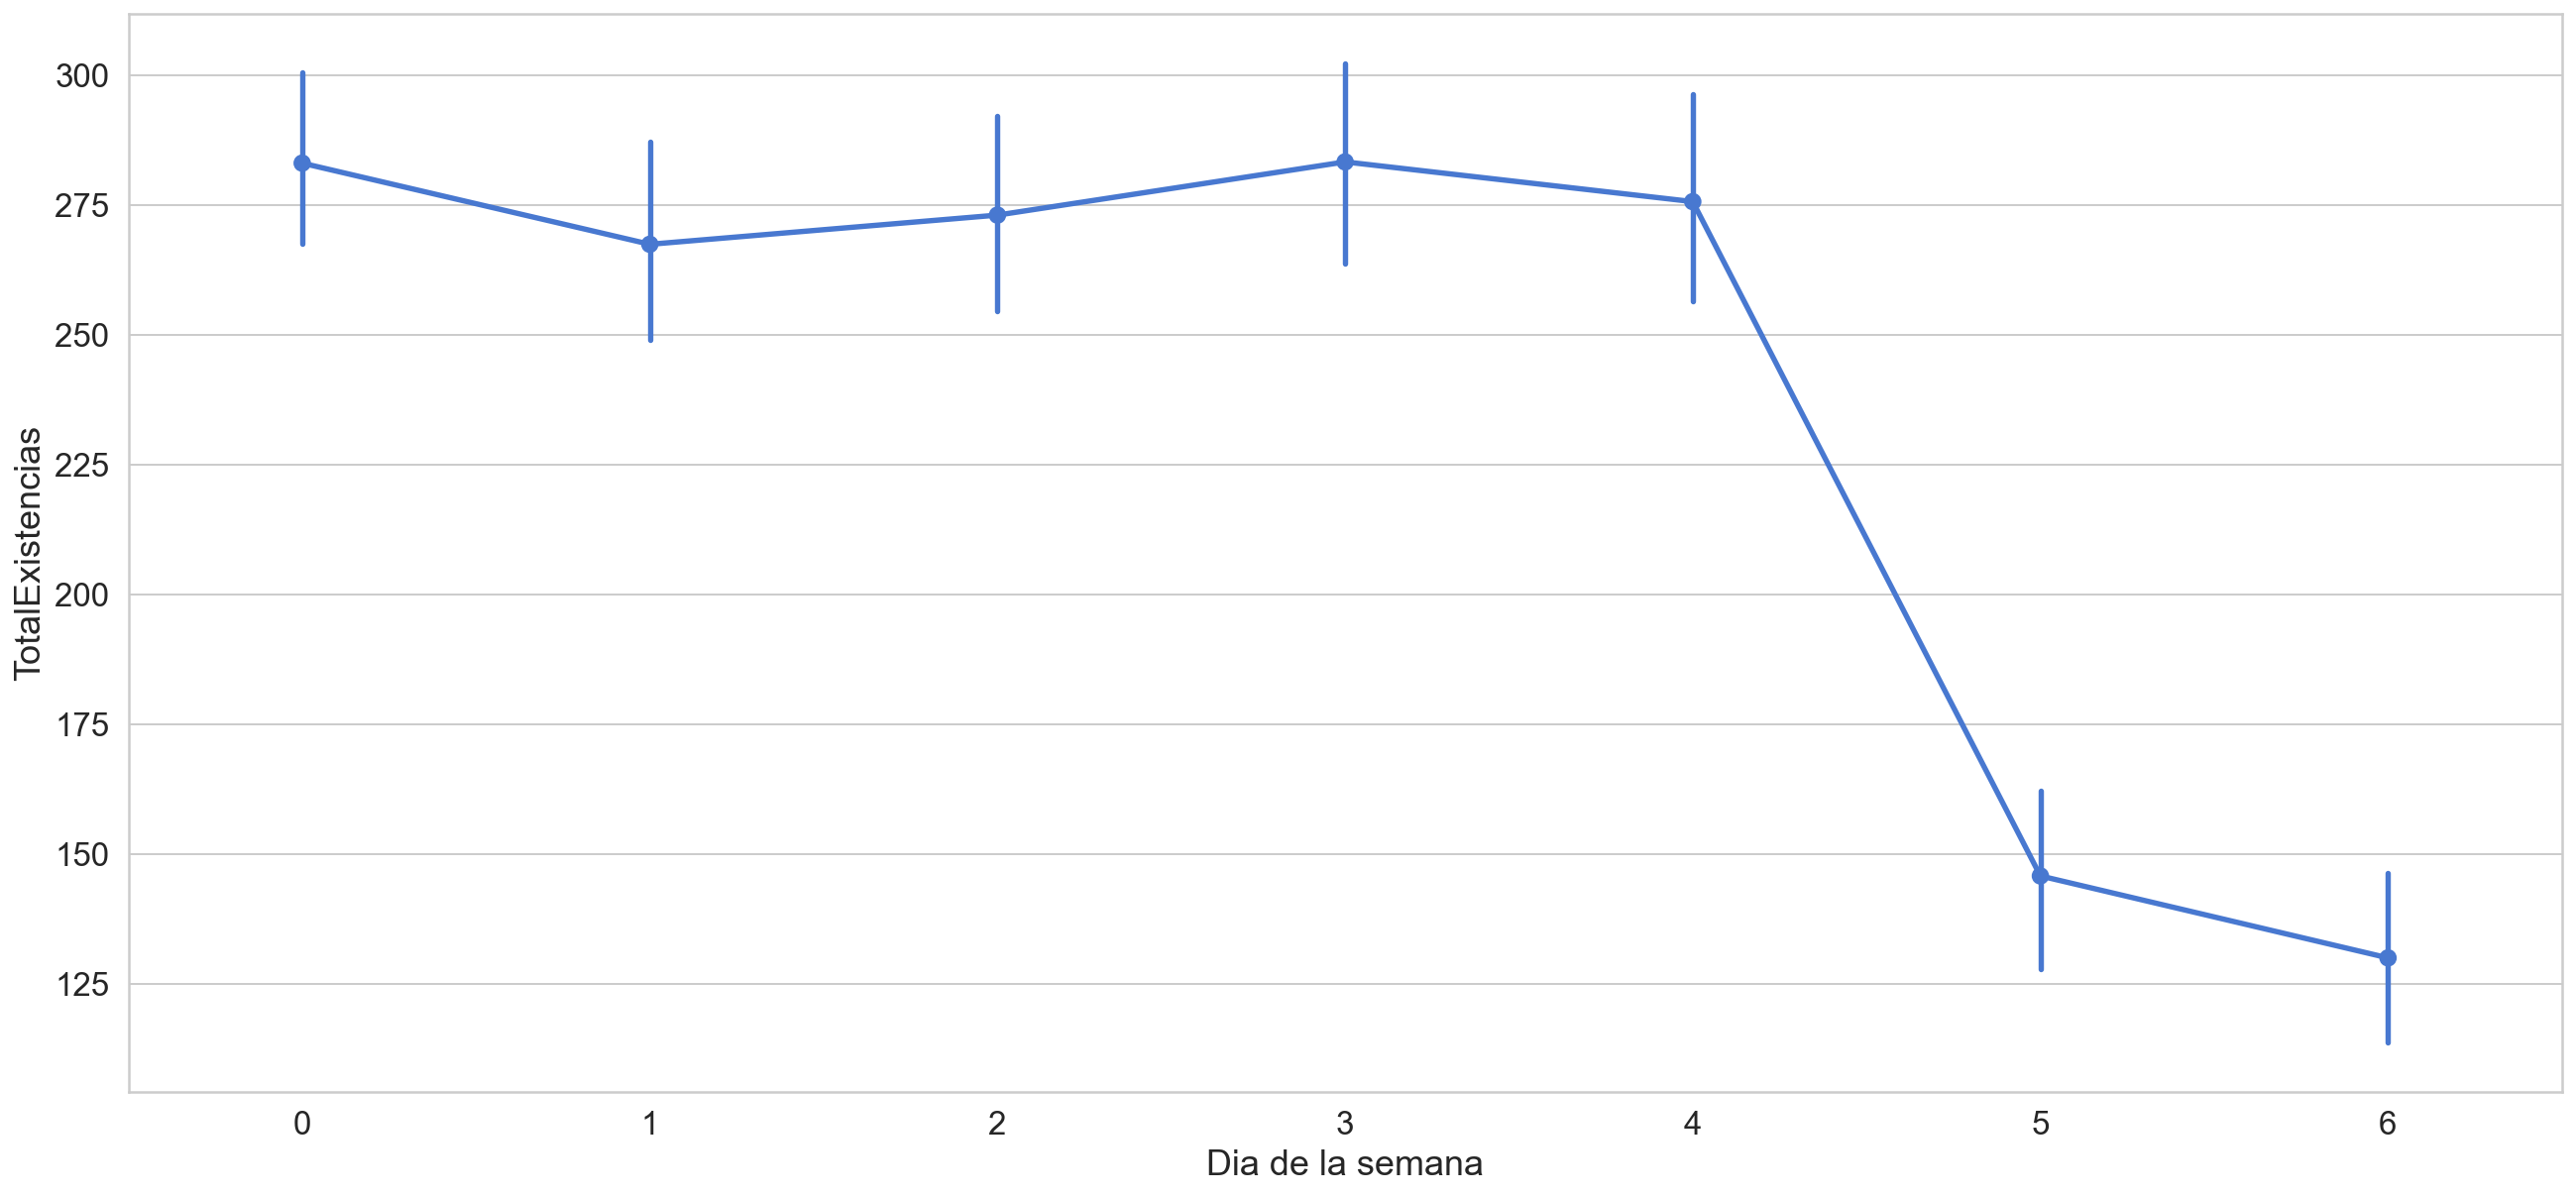

In [12]:
sns.pointplot(data=df, x='Dia de la semana', y='TotalExistencias')

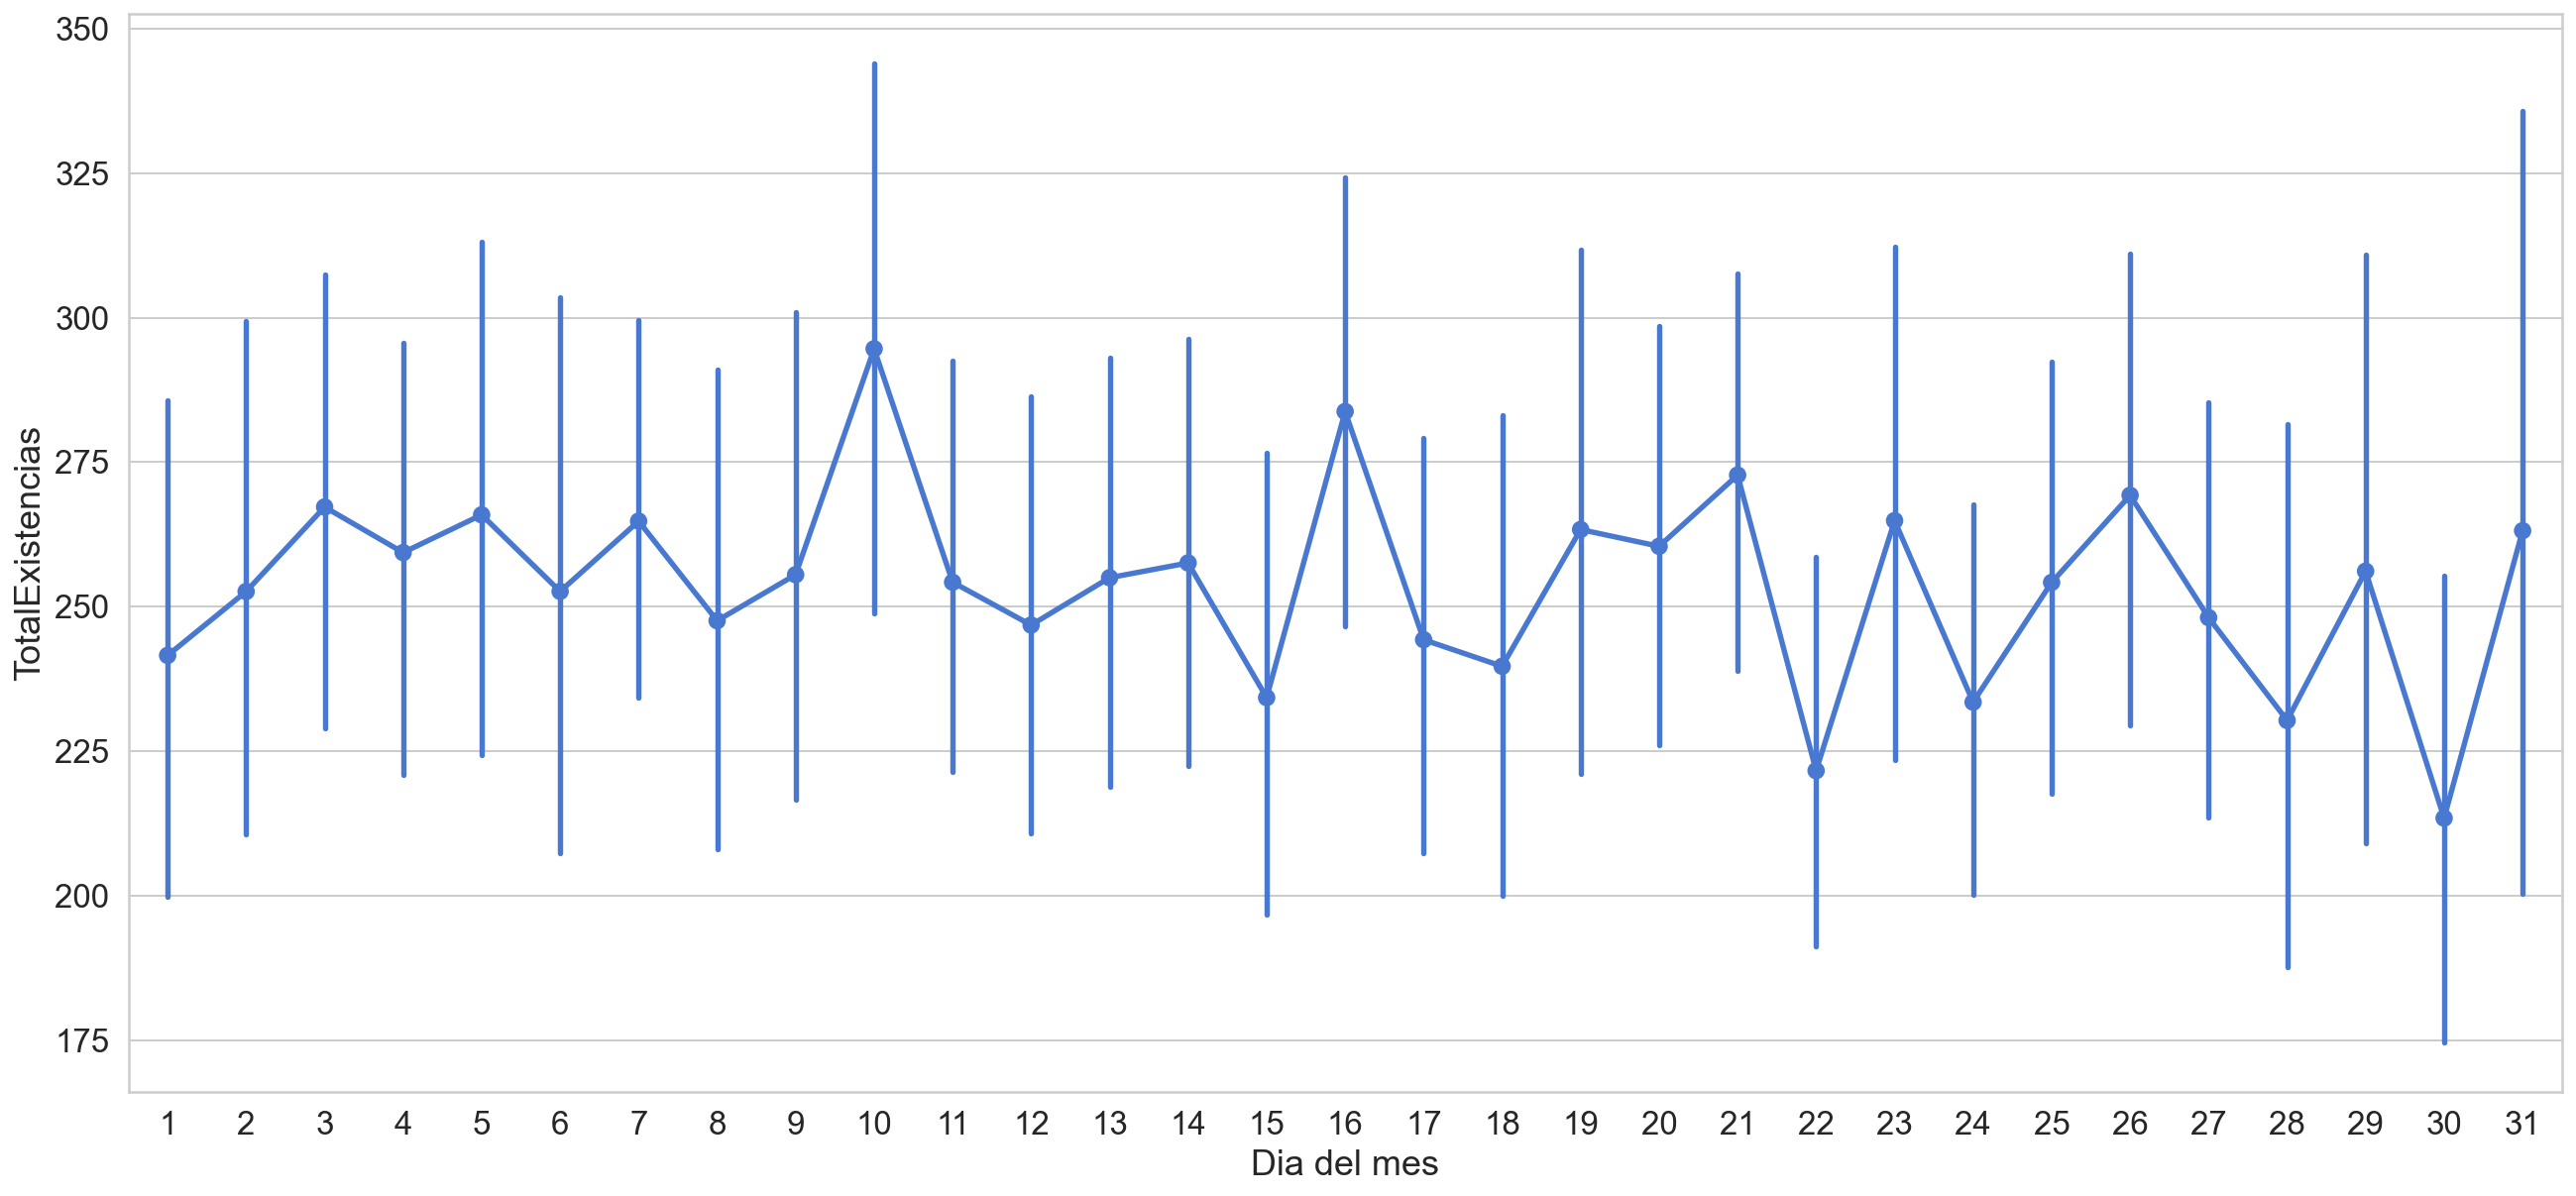

In [13]:
sns.pointplot(data=df, x='Dia del mes', y='TotalExistencias')

In [14]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size] , df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(3157, 4) (351, 4)


In [15]:
from sklearn.preprocessing import RobustScaler
testfuturo = df2
#f_columns = ['caracteristicassincontarTotalExistencias']

#f_transformer = RobustScaler()  #por si hubiera más características en la tabla
cnt_transformer = RobustScaler()

#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['TotalExistencias']])

#train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy()) #transformamos el resto de características
train['TotalExistencias'] = cnt_transformer.transform(train[['TotalExistencias']])

#test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy()) #transformamos el resto de características
test['TotalExistencias'] = cnt_transformer.transform(test[['TotalExistencias']])
testfuturo['TotalExistencias'] = cnt_transformer.transform(df2[['TotalExistencias']])

C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Es importante eliminar del conjunto X_train los labels para que no se "haga trampa"

In [16]:
train_labels = train['TotalExistencias']
test_labels = test['TotalExistencias']
test_futuro_labels = testfuturo['TotalExistencias']

In [17]:
train.drop(columns=['TotalExistencias'],inplace=True) 
test.drop(columns=['TotalExistencias'],inplace=True)
testfuturo.drop(columns=['TotalExistencias'],inplace=True)

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Tenemos que transformar los datos en trozos de series temporales

In [18]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [19]:
TIME_STEPS = 10

X_train, y_train = create_dataset(train,train_labels,time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test,test_labels,time_steps=TIME_STEPS)


In [20]:
X_test_futuro, y_test_futuro = create_dataset(testfuturo, test_futuro_labels,time_steps=TIME_STEPS)

In [21]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3147, 10, 3) (3147,)
(341, 10, 3) (341,)


In [22]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

### Desarrollamos el modelo

In [23]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1],X_train.shape[2])  #10 y 4
        )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1)) #la salida es 1 número

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
#NO QUEREMOS MEZCLARLO PORQUE EL TS DEPENDE DEL ORDEN
history = model.fit(
    X_train,y_train,
    epochs=150,
    batch_size=24,  
    validation_split=0.1,
    shuffle=False)

Train on 2832 samples, validate on 315 samples
Epoch 1/150
2832/2832 [==============================] - 4s 1ms/sample - loss: 1.0889 - val_loss: 0.3333
Epoch 2/150
2832/2832 [==============================] - 1s 205us/sample - loss: 0.9982 - val_loss: 0.3004
Epoch 3/150
2832/2832 [==============================] - 1s 219us/sample - loss: 0.9731 - val_loss: 0.3163
Epoch 4/150
2832/2832 [==============================] - 1s 214us/sample - loss: 0.9569 - val_loss: 0.3687
Epoch 5/150
2832/2832 [==============================] - 1s 215us/sample - loss: 0.9474 - val_loss: 0.4118
Epoch 6/150
2832/2832 [==============================] - 1s 210us/sample - loss: 0.9343 - val_loss: 0.4437
Epoch 7/150
2832/2832 [==============================] - 1s 212us/sample - loss: 0.9331 - val_loss: 0.4788
Epoch 8/150
2832/2832 [==============================] - 1s 211us/sample - loss: 0.9260 - val_loss: 0.4950
Epoch 9/150
2832/2832 [==============================] - 1s 223us/sample - loss: 0.9229 - val_loss:

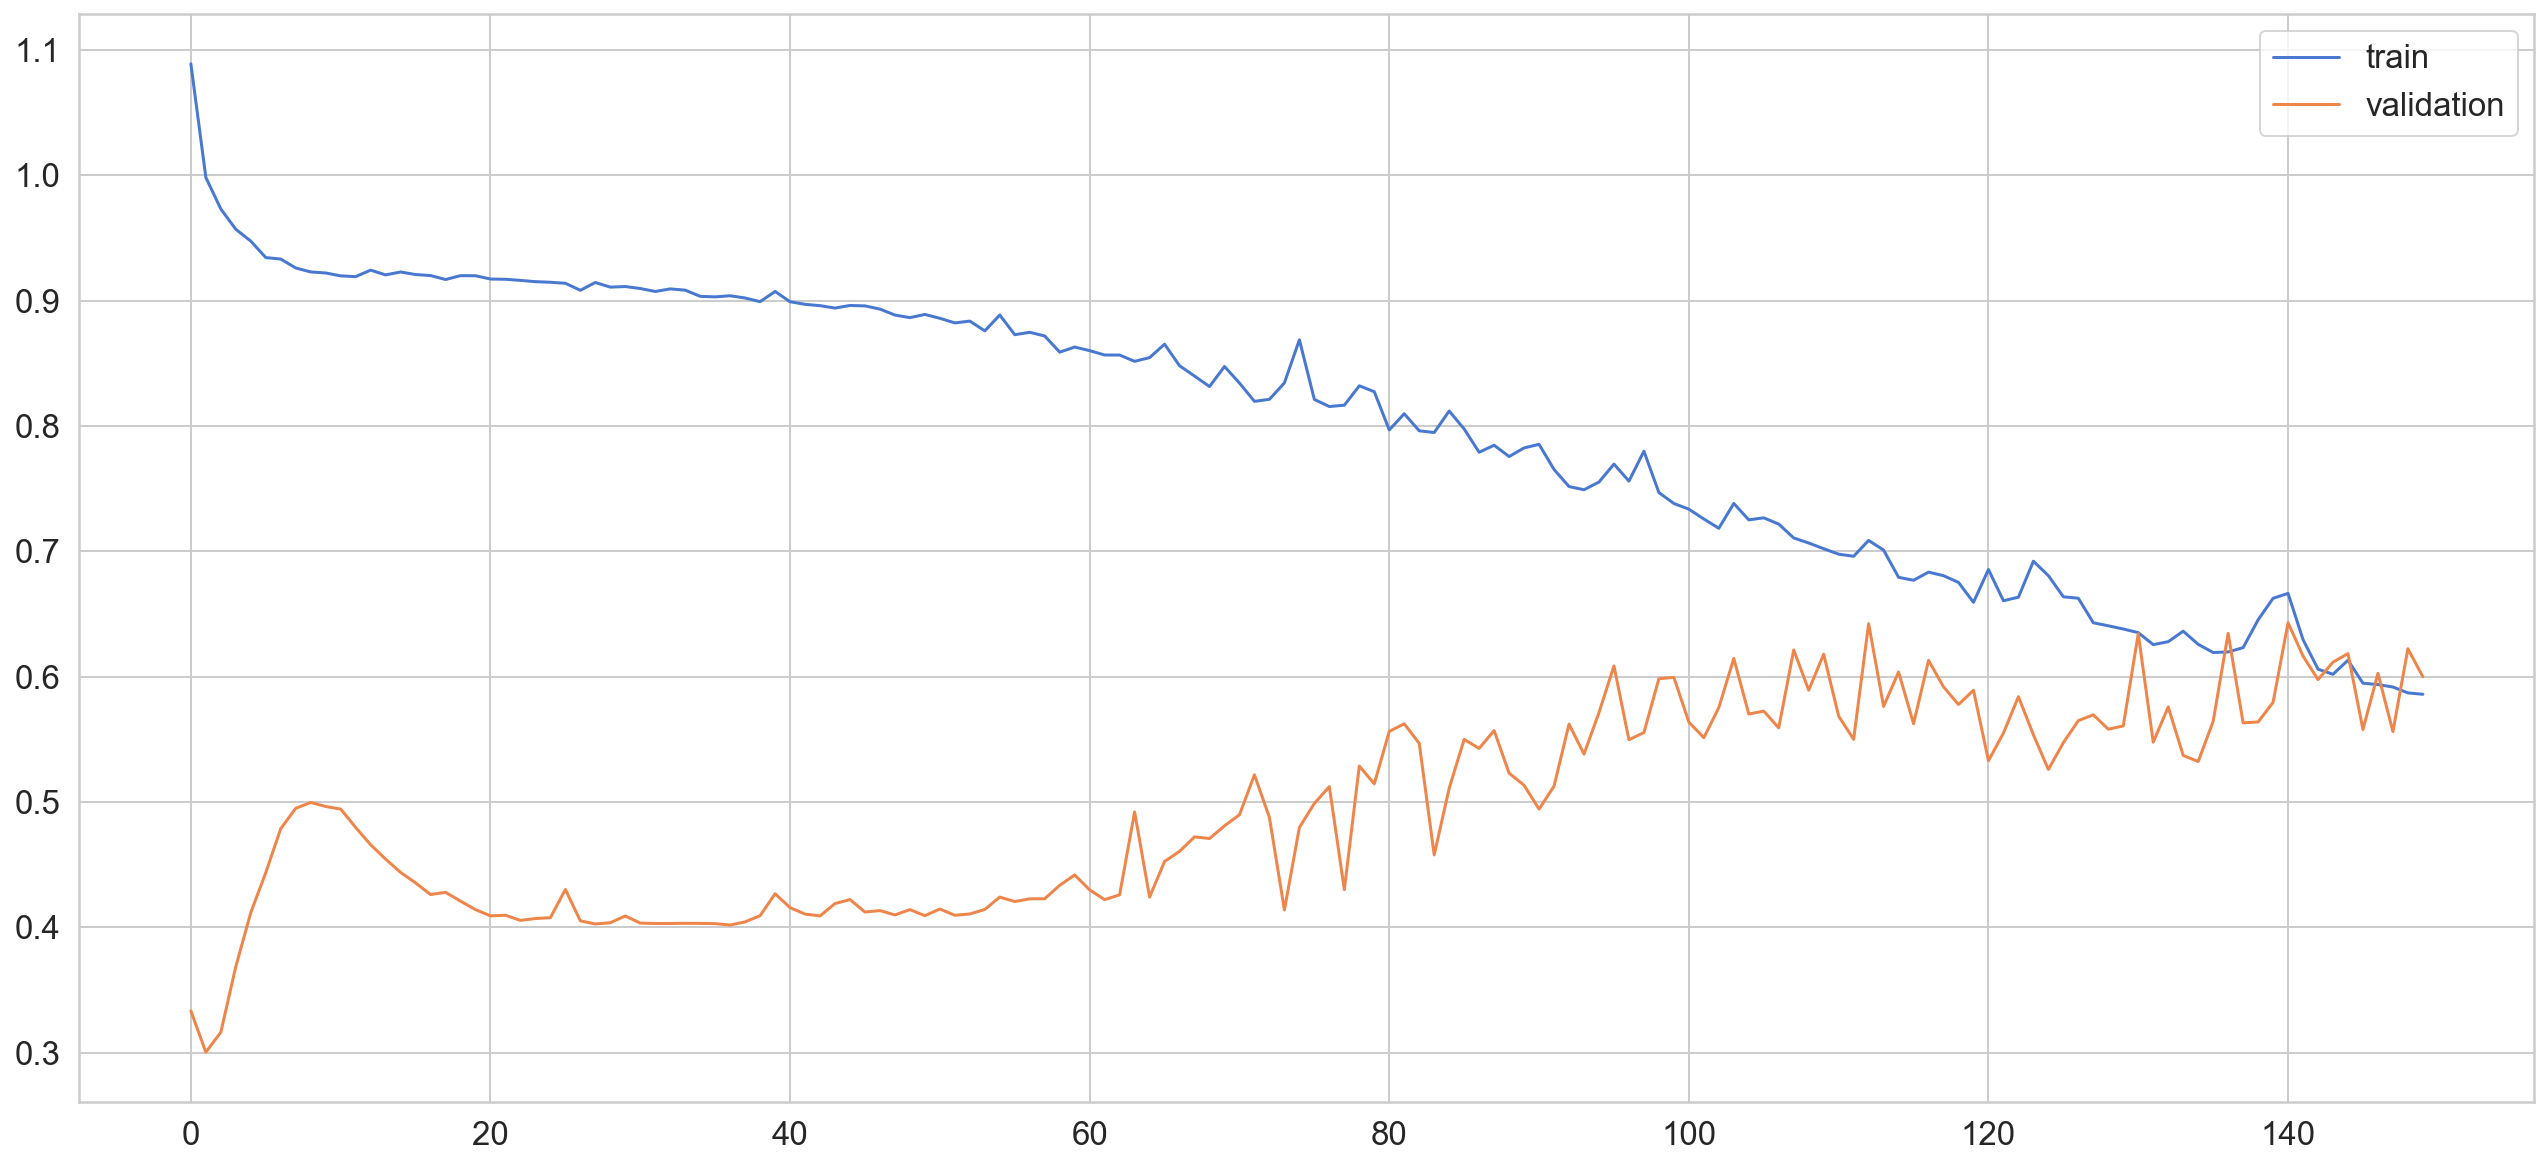

In [26]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [27]:
y_pred = model.predict(X_test)

In [28]:
y_pred.shape

(341, 1)

In [29]:
y_pred

array([[ 9.10244823e-01],
       [ 4.31184381e-01],
       [ 4.16902035e-01],
       [ 1.32173800e+00],
       [ 1.07748425e+00],
       [ 5.65761387e-01],
       [ 4.05760646e-01],
       [ 4.33713675e-01],
       [ 5.92393279e-01],
       [-2.84110010e-03],
       [ 2.63819218e-01],
       [ 4.88458037e-01],
       [ 2.53044009e-01],
       [ 4.97833490e-01],
       [ 4.11863446e-01],
       [ 4.33842003e-01],
       [-3.83705378e-01],
       [-3.14675122e-02],
       [ 1.06072736e+00],
       [ 8.41593385e-01],
       [ 5.10630965e-01],
       [ 3.90784168e+00],
       [ 6.72493339e-01],
       [ 1.75044024e+00],
       [ 2.25498581e+00],
       [ 2.43167877e-01],
       [-1.84615403e-02],
       [ 4.85720694e-01],
       [ 8.85765135e-01],
       [-4.73172784e-01],
       [ 4.89939302e-02],
       [ 4.02477324e-01],
       [ 8.29429209e-01],
       [ 2.52577603e-01],
       [ 3.89282763e-01],
       [ 9.04323578e-01],
       [ 5.19338608e-01],
       [ 6.24680877e-01],
       [-6.3

In [30]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

In [31]:
y_train

array([ 2.68979592,  1.17142857,  1.81632653, ..., -0.66122449,
        0.30612245, -0.24897959])

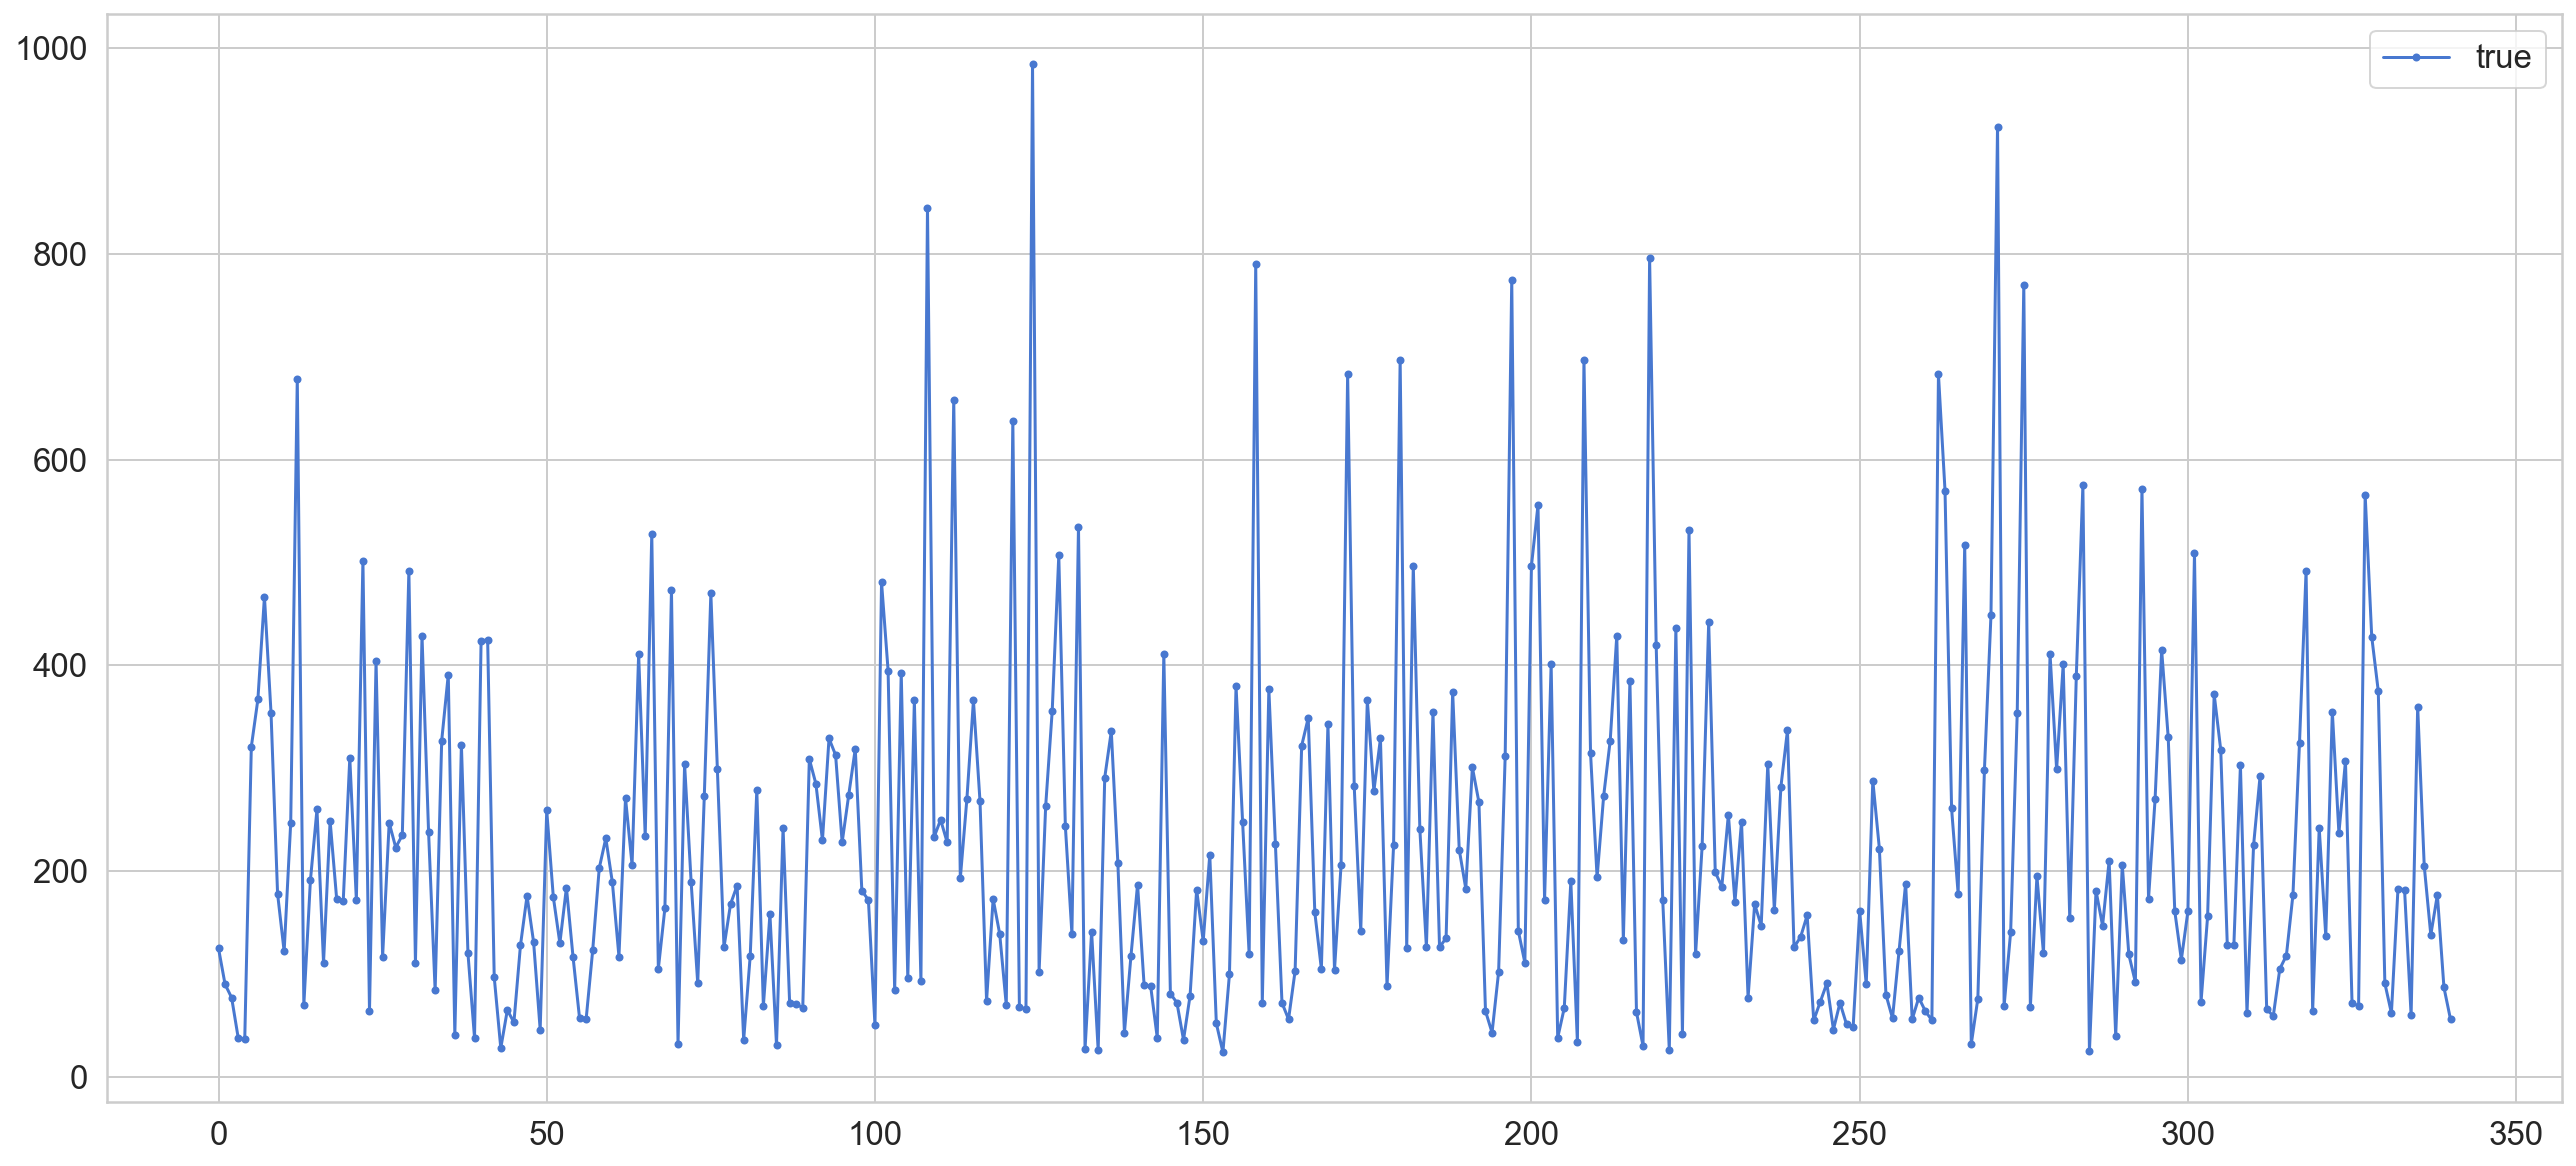

In [32]:
plt.plot(y_test_inv.flatten(),marker='.',label='true')
plt.legend();

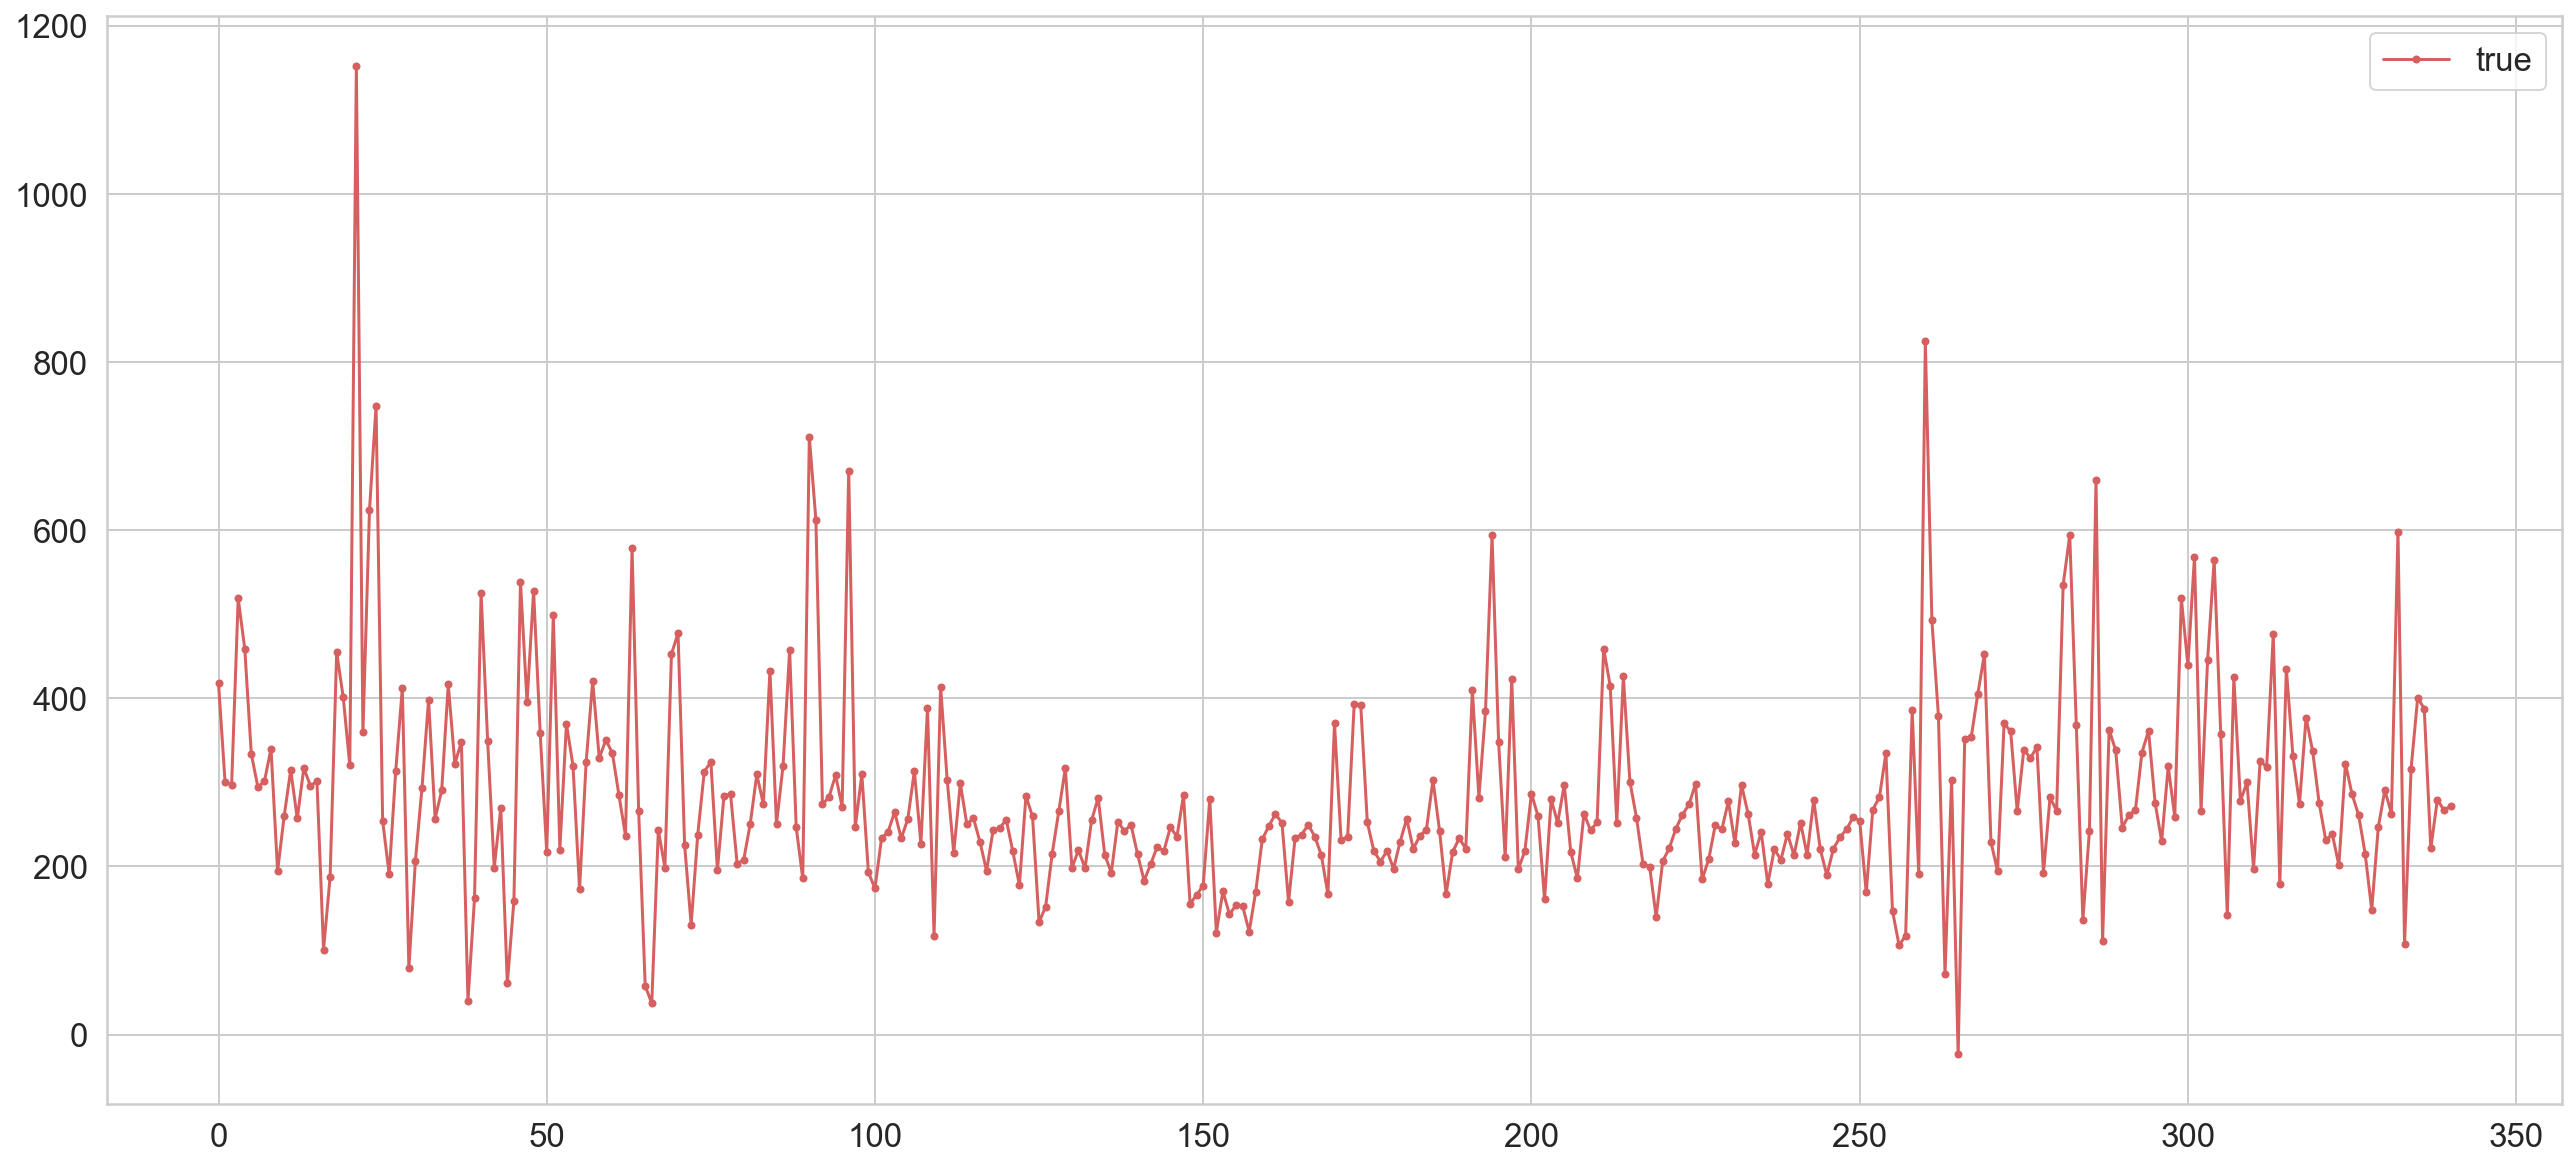

In [33]:
plt.plot(y_pred_inv.flatten(),'r',marker='.',label='true')
plt.legend();

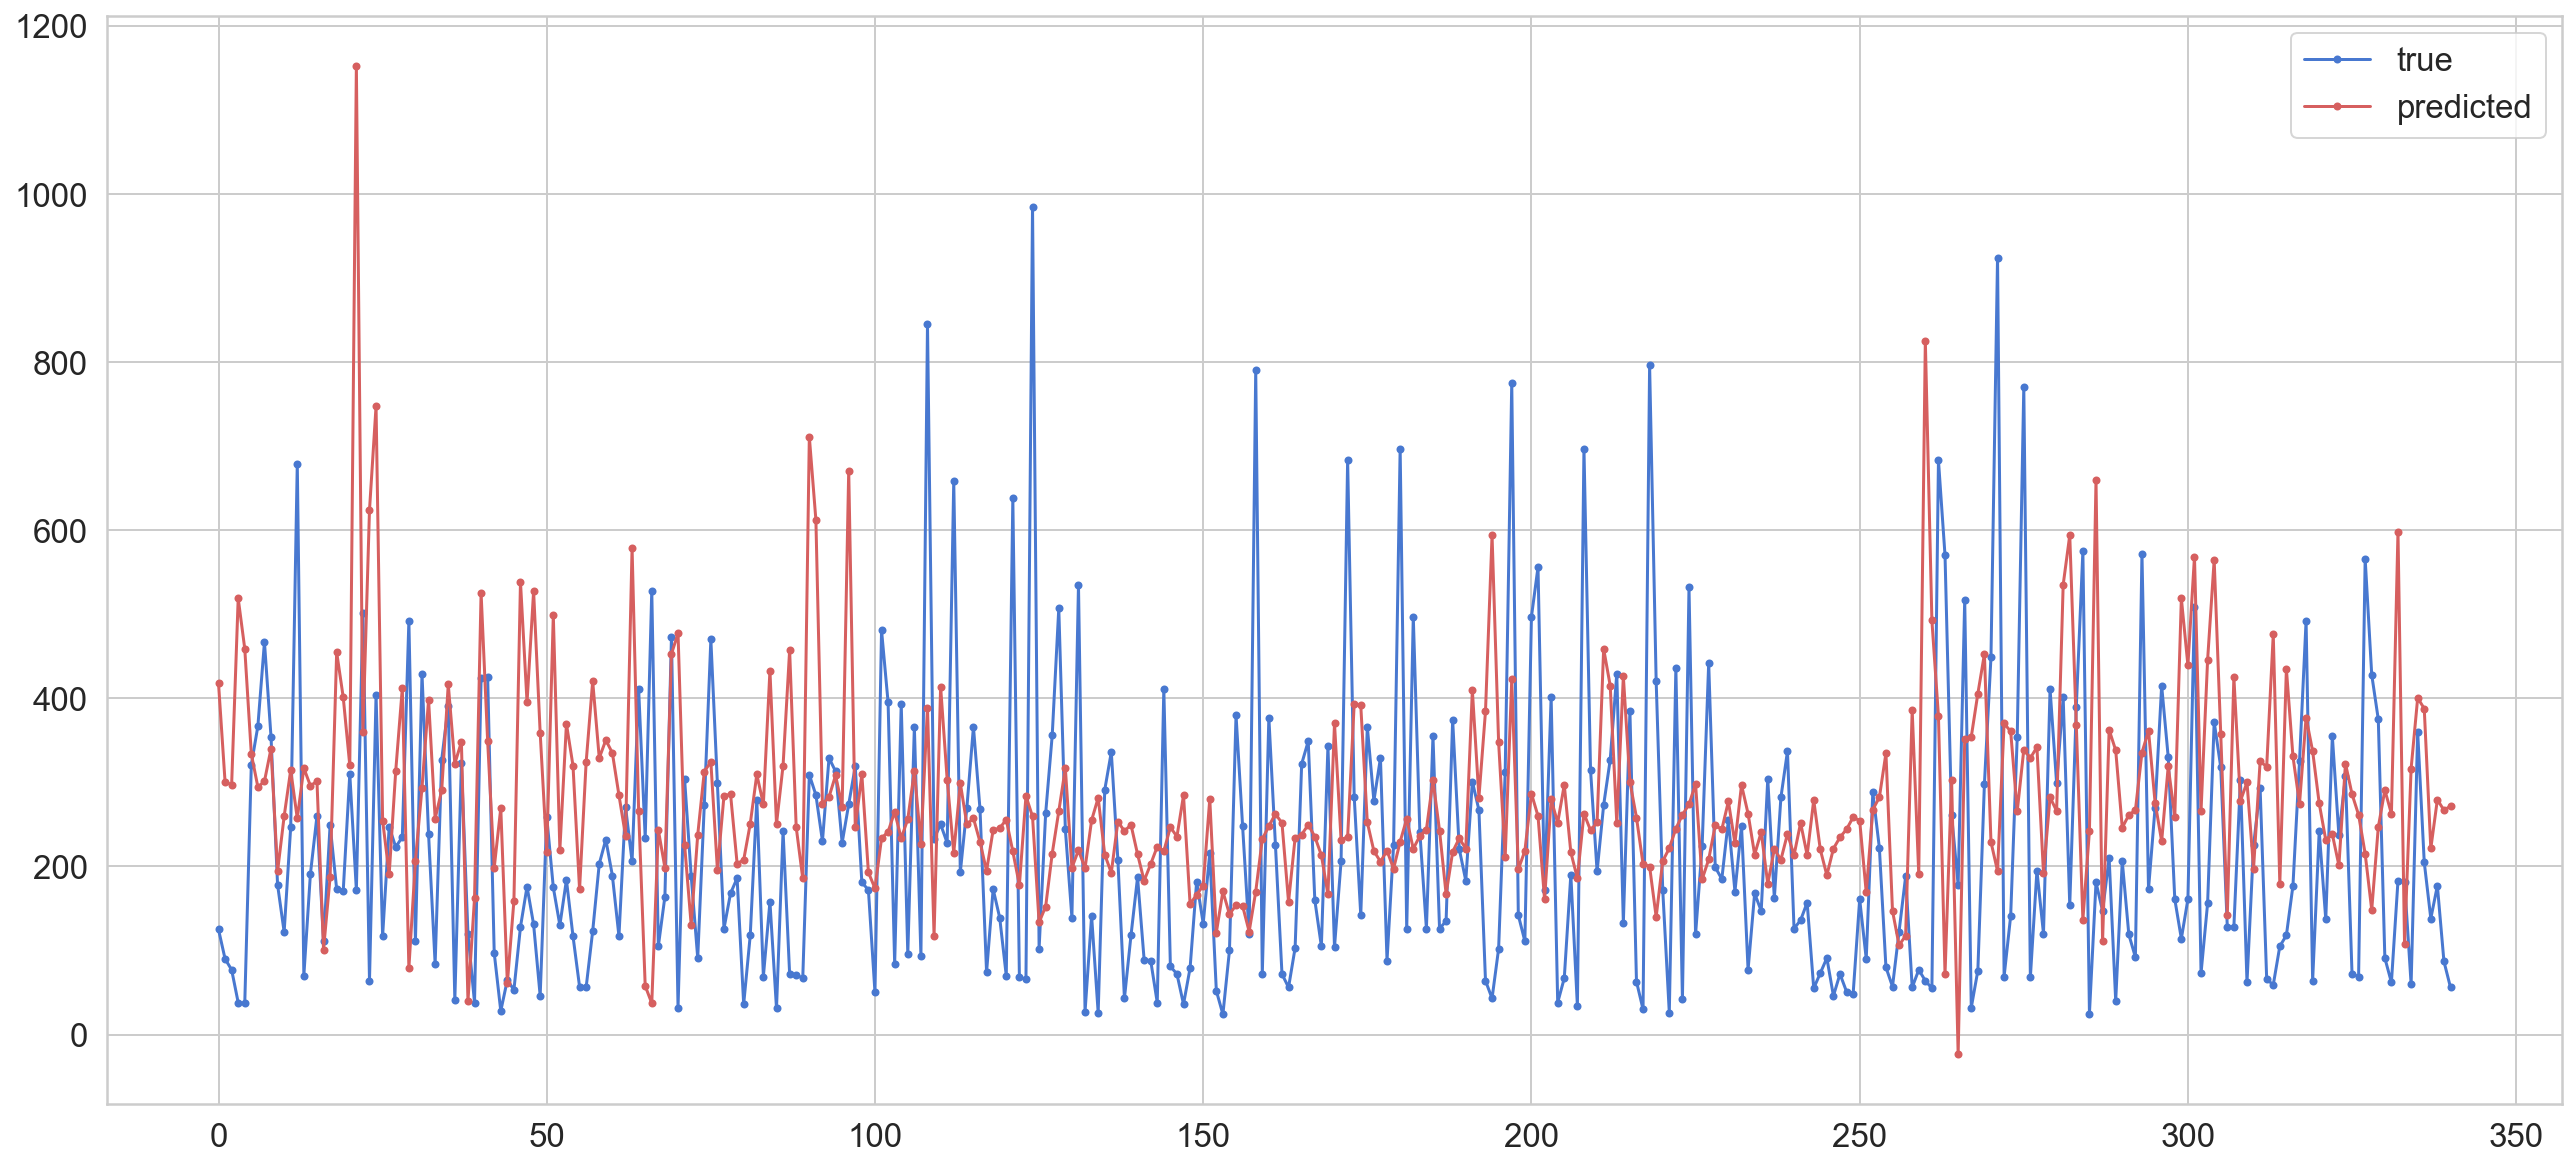

In [34]:
plt.plot(y_test_inv.flatten(),marker='.',label='true')
plt.plot(y_pred_inv.flatten(),'r', marker= '.',label='predicted')
plt.legend();

In [35]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 0.907


In [36]:
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

MSE: 0.823


In [37]:
y_pred = model.predict(X_test_futuro)

In [38]:
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

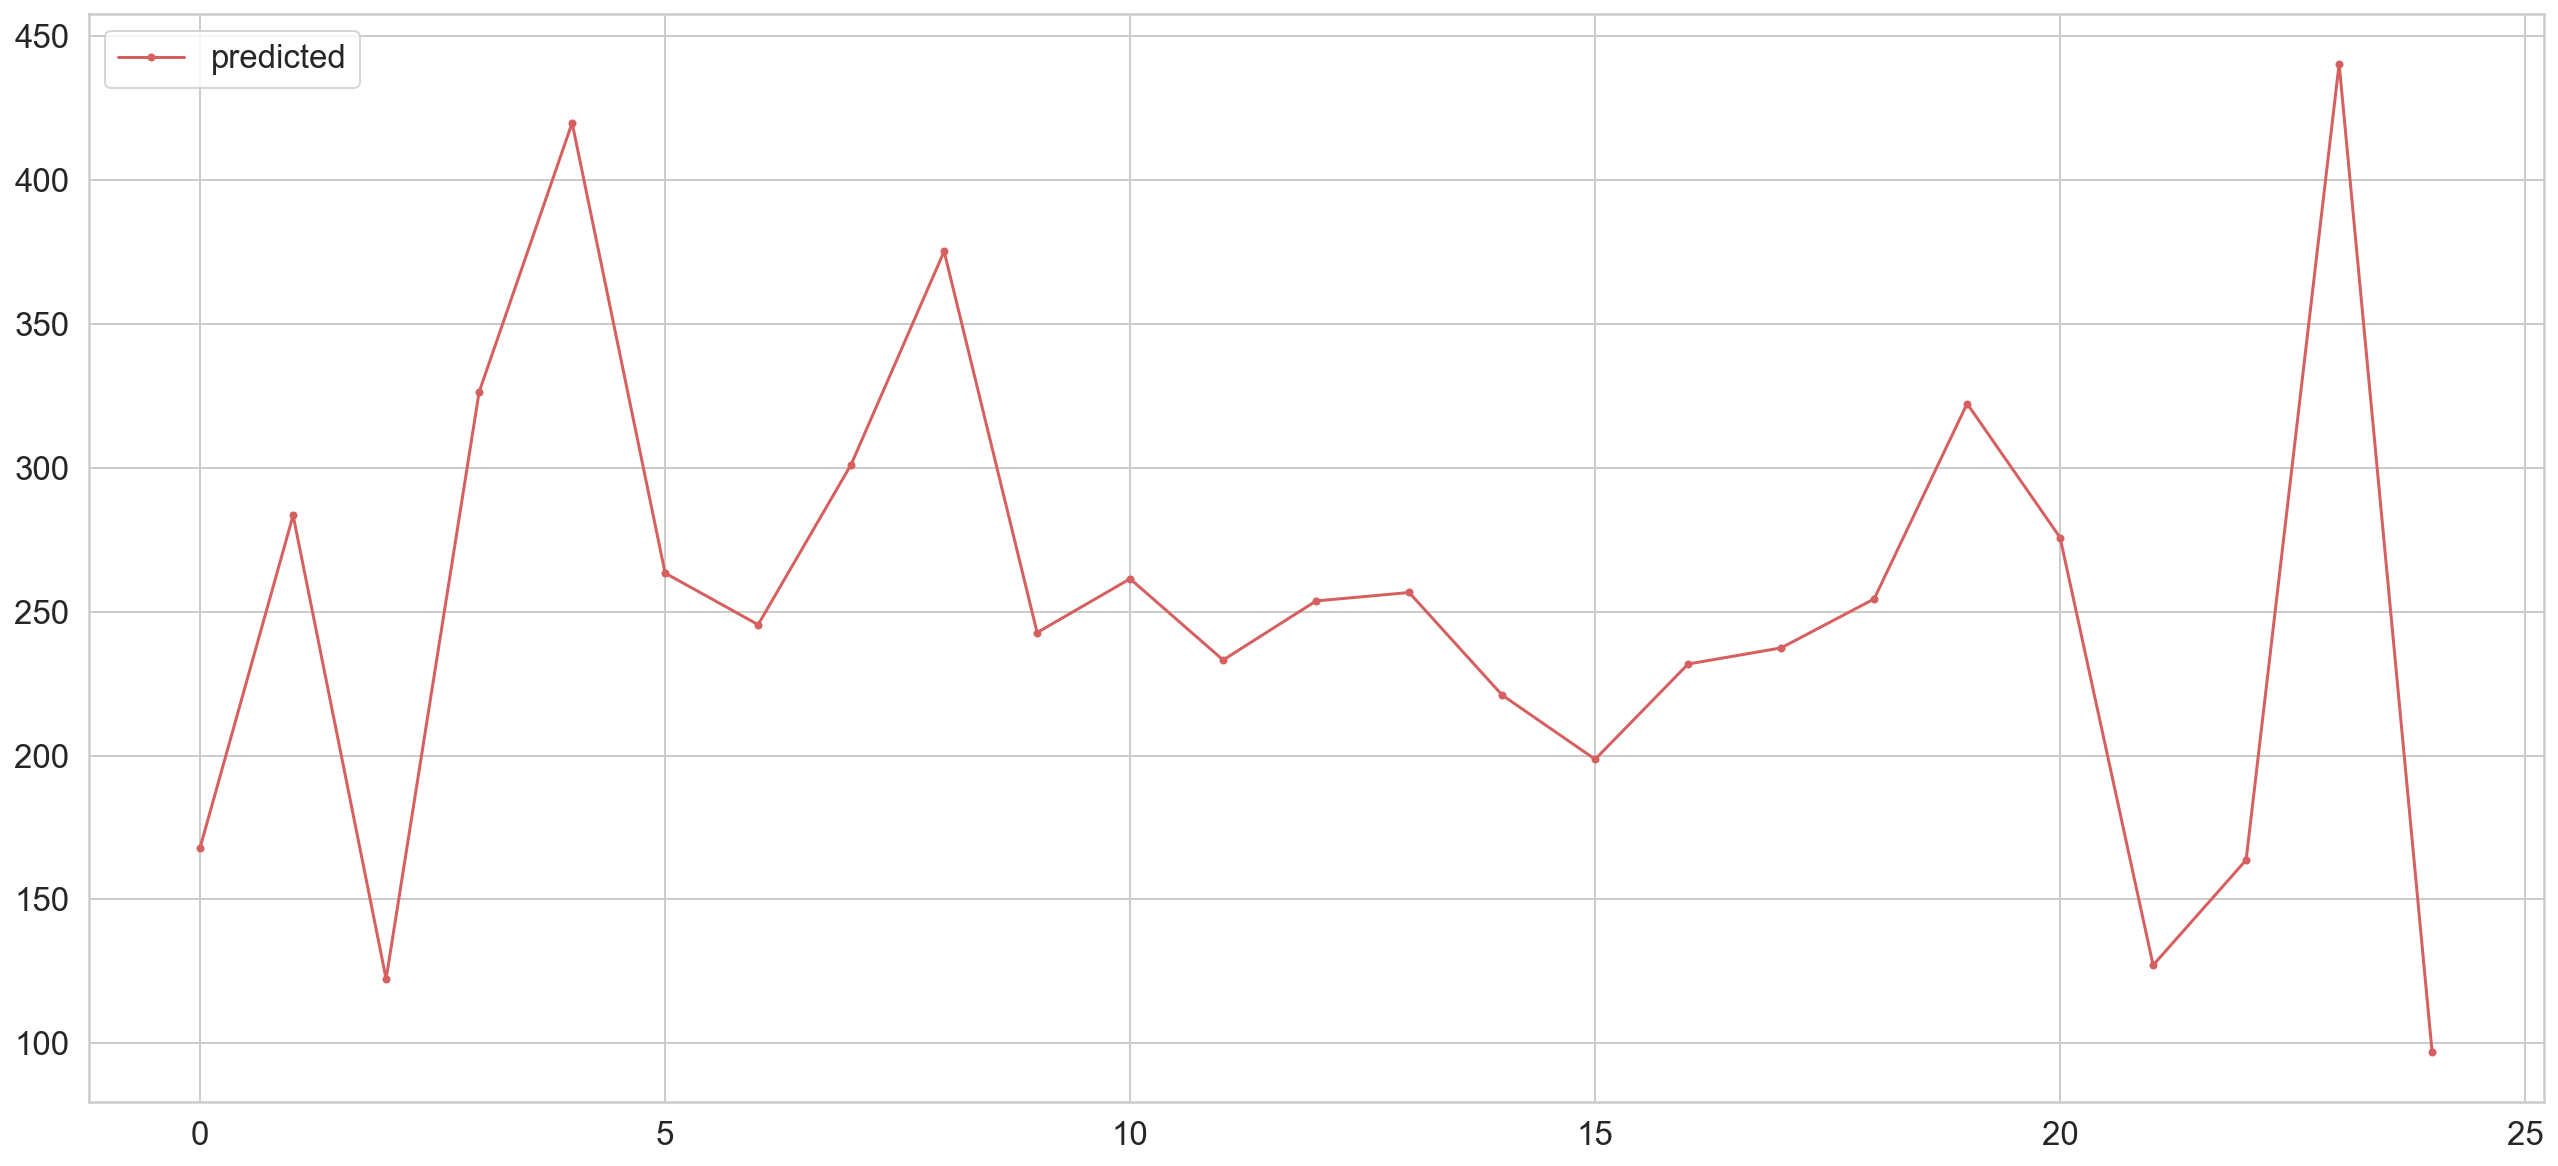

In [39]:
plt.plot(y_pred_inv.flatten(),'r', marker= '.',label='predicted')
plt.legend();

In [40]:
total_pred_inv = np.concatenate((y_test_inv.flatten(), y_pred_inv.flatten()))

In [41]:
total_pred_inv_index = np.arange(len(total_pred_inv))

In [42]:
total_pred_df = pd.DataFrame(data=total_pred_inv,index=total_pred_inv_index, columns=['True'])

In [43]:
y_pred_inv = y_pred_inv.flatten()

In [44]:
y_pred_inv_index = total_pred_inv_index[-len(y_pred_inv):]

In [45]:
y_pred_inv_df = pd.DataFrame(data=y_pred_inv,index=y_pred_inv_index,columns=['Forecast'])

In [46]:
#total_pred_df

In [47]:
#y_pred_inv_df

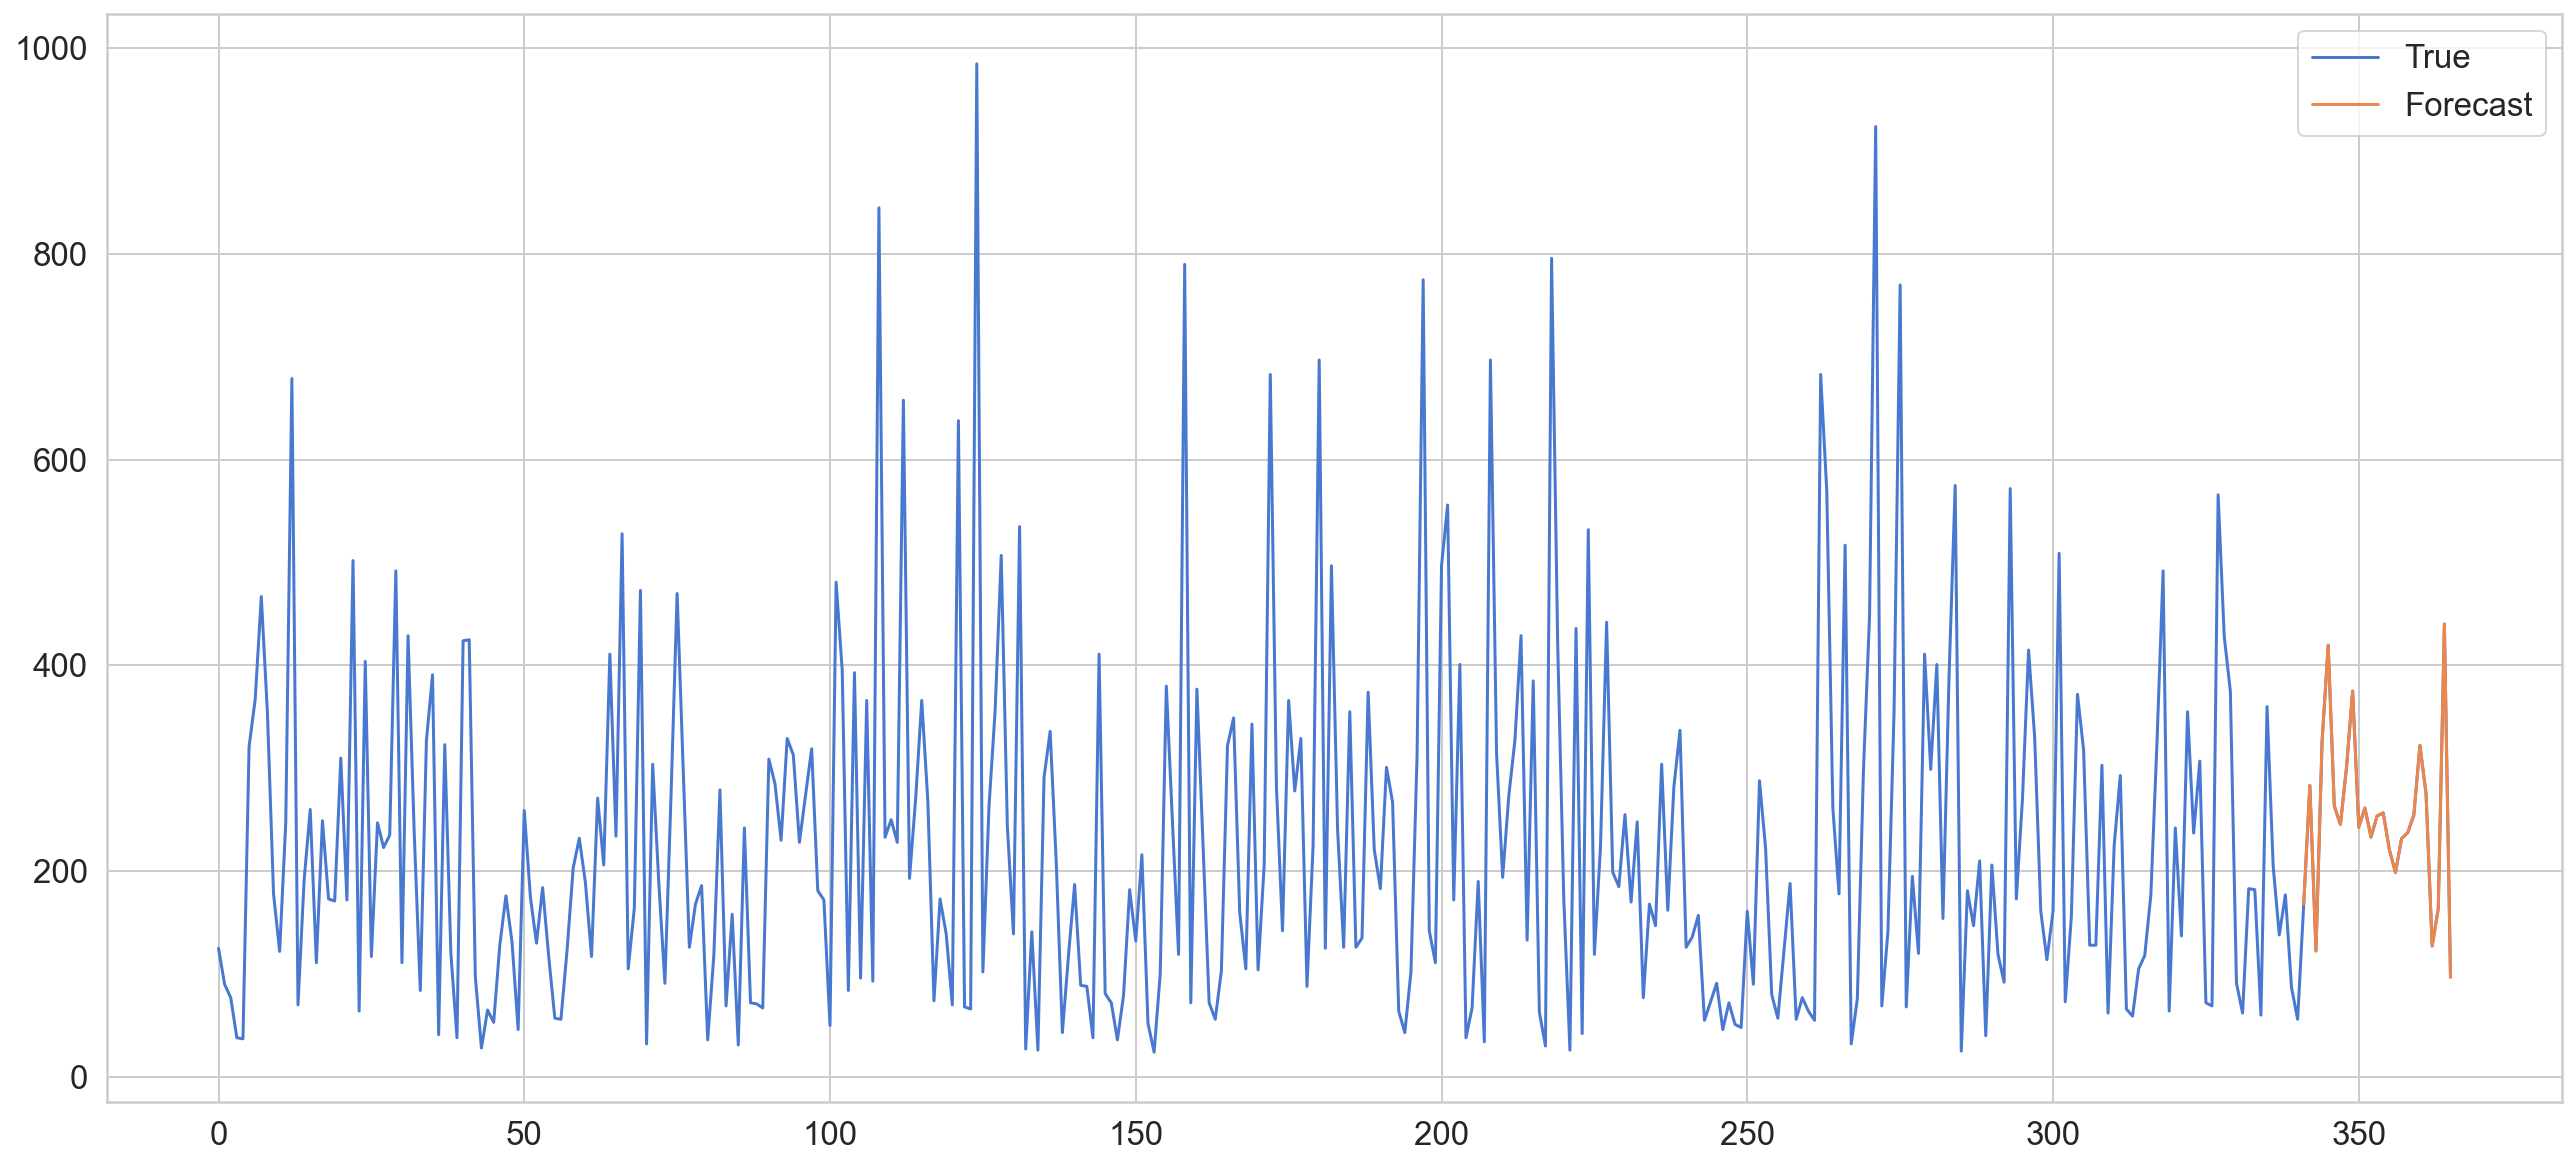

In [48]:
ax = total_pred_df.plot()
y_pred_inv_df.plot(ax=ax)

# Neumaticos

In [49]:
df = pd.read_sql_query("Select Fecha, sum(Existencias) TotalExistencias from Movimientos where FamiliaDesc NOT IN ('COMBUSTIBLES','ADITIVOS PARA LA COMBUSTION','LUBRICANTES','LÍQUIDOS REFRIGERANTES','CASCOS (NO INVENTARIABLE)','UTILES DE PERSONAL','UNIFORMES') AND Fecha > '2008-01-01' AND ArticuloDesc NOT IN ('no existe viene mal de PICK','PASTA MANOS',' ...........  no usar ...............', '..', 'PASTA MANOS ZORKIL-C35') AND FamiliaDesc = 'NEUMATICOS NUEVOS' AND ArticuloDesc = 'CUBIERTA NUEVA 275/70 R-22.5 METROPOLITANO/URBANO' group by Fecha;",con,parse_dates=['Fecha'],index_col='Fecha')

In [50]:
df2 =  read_csv('PredicciónMovimientosNeumáticos.csv', parse_dates=['Fecha'],index_col='Fecha')

### Primero análisis exploratorio

In [51]:
df['Dia de la semana'] = df.index.dayofweek
df['Dia del mes'] = df.index.day
df['Mes'] = df.index.month
df2['Dia de la semana'] = df2.index.dayofweek
df2['Dia del mes'] = df2.index.day
df2['Mes'] = df2.index.month

In [52]:
df.head()

TotalExistencias  Dia de la semana  Dia del mes  Mes
Fecha                                                           
2012-09-10              16.0                 0           10    9
2012-09-11              20.0                 1           11    9
2012-09-13              46.0                 3           13    9
2012-09-24              23.0                 0           24    9
2012-09-28              19.0                 4           28    9

In [53]:
df.tail()

TotalExistencias  Dia de la semana  Dia del mes  Mes
Fecha                                                           
2019-08-02              69.0                 4            2    8
2019-08-05              19.0                 0            5    8
2019-08-06              88.0                 1            6    8
2019-08-09              10.0                 4            9    8
2019-08-12               0.0                 0           12    8

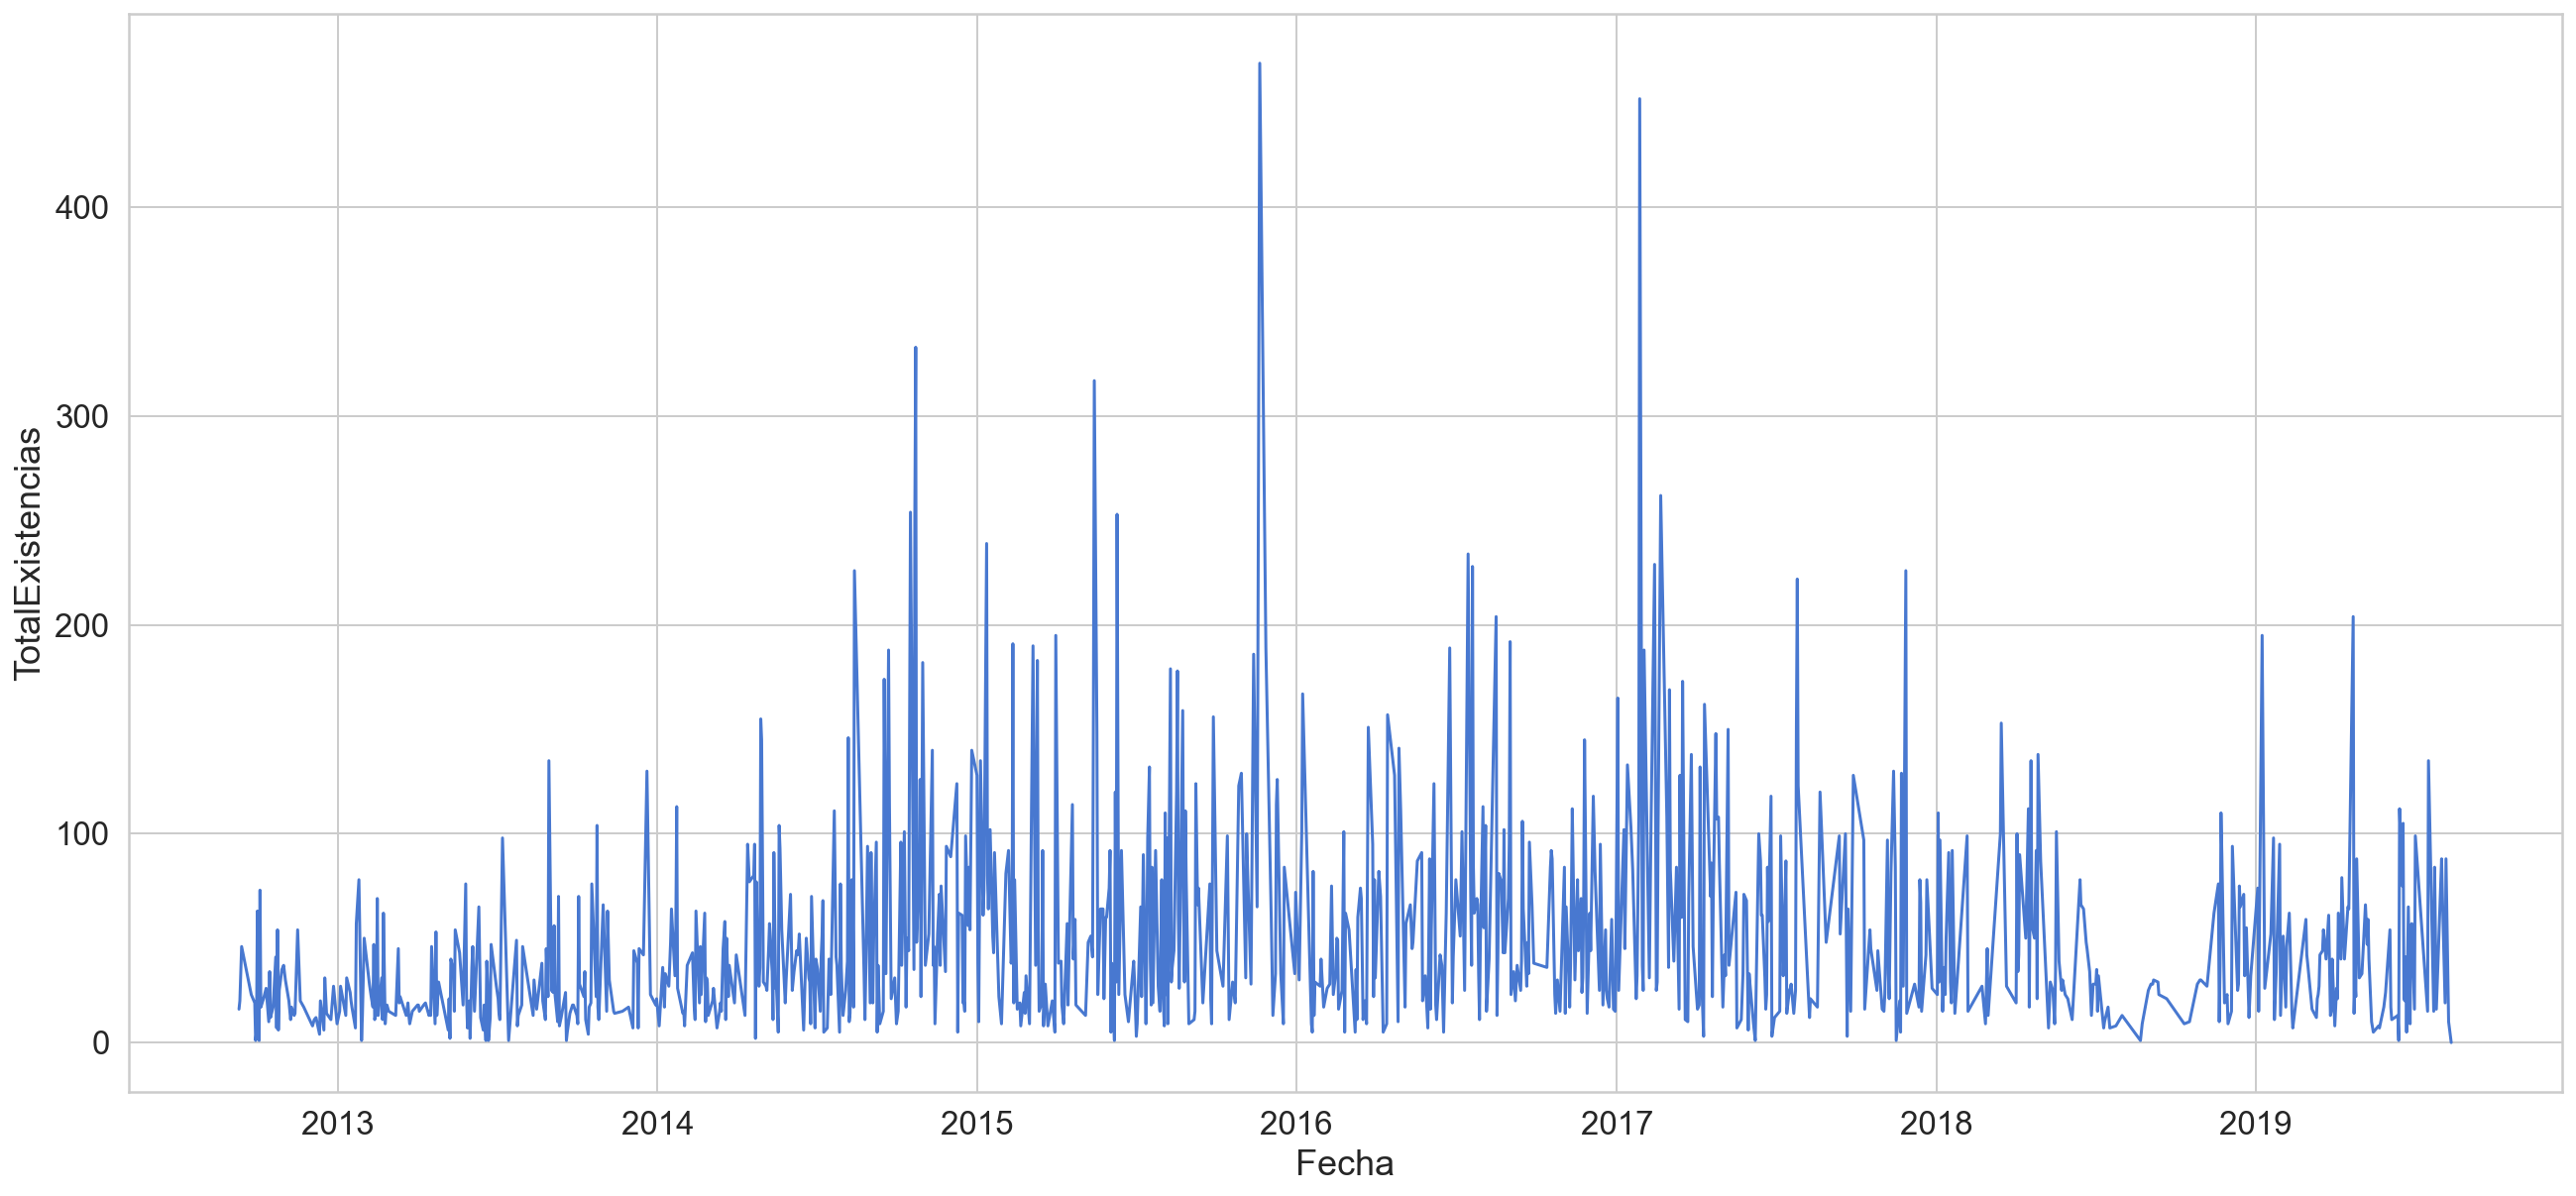

In [54]:
sns.lineplot(x=df.index, y='TotalExistencias', data=df)

### Aquí podemos ver si hay estacionalidad

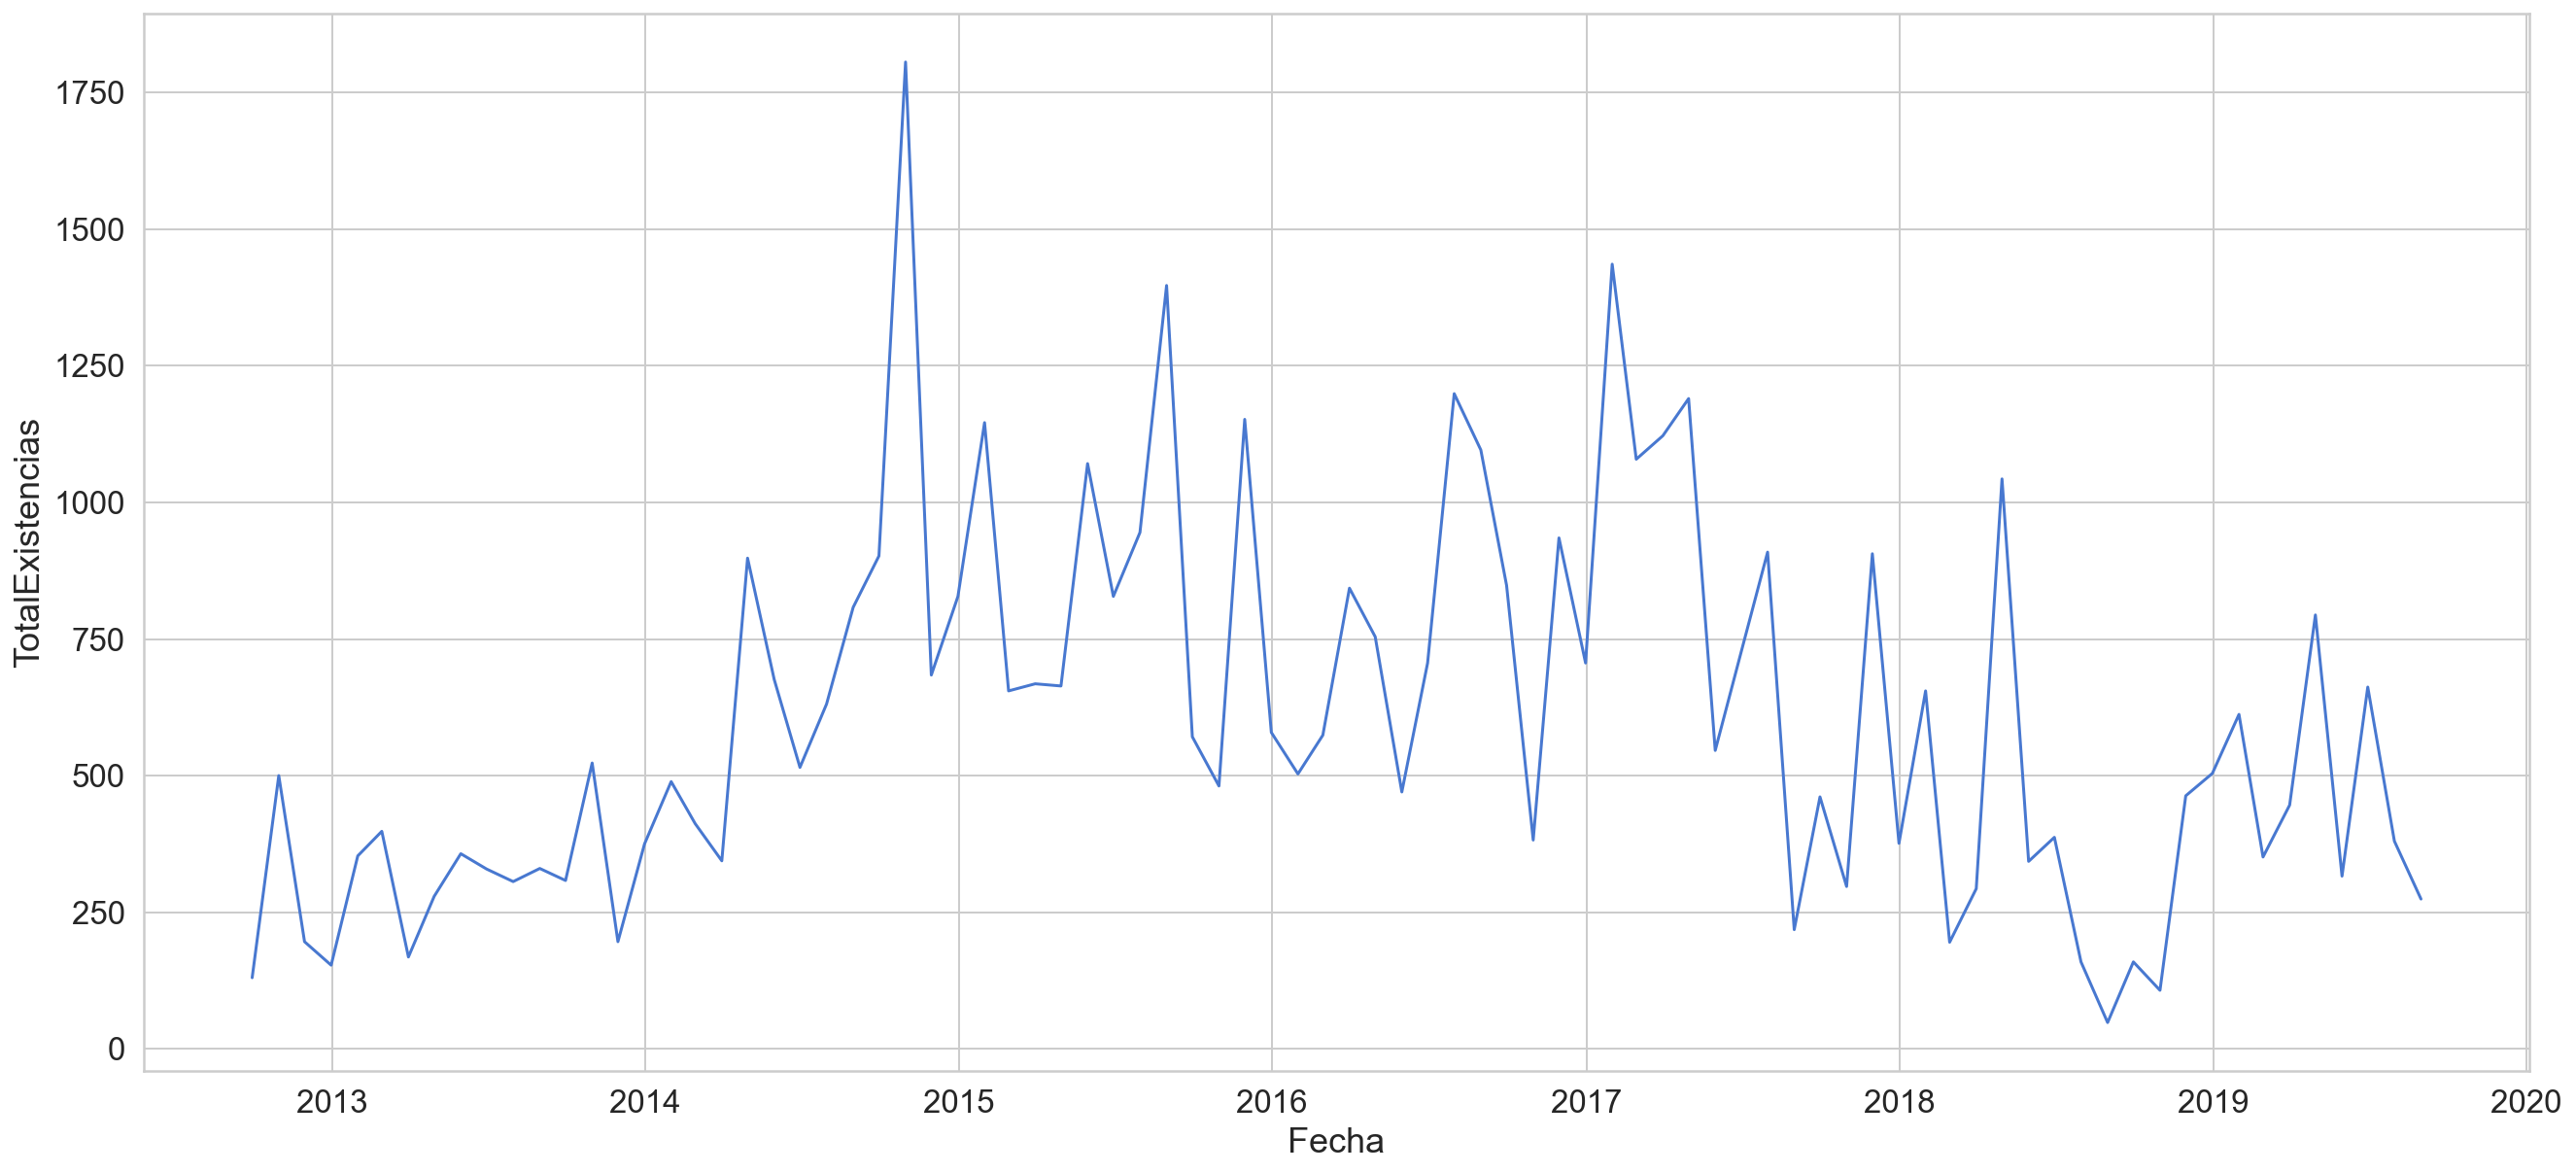

In [55]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y='TotalExistencias',data=df_by_month)

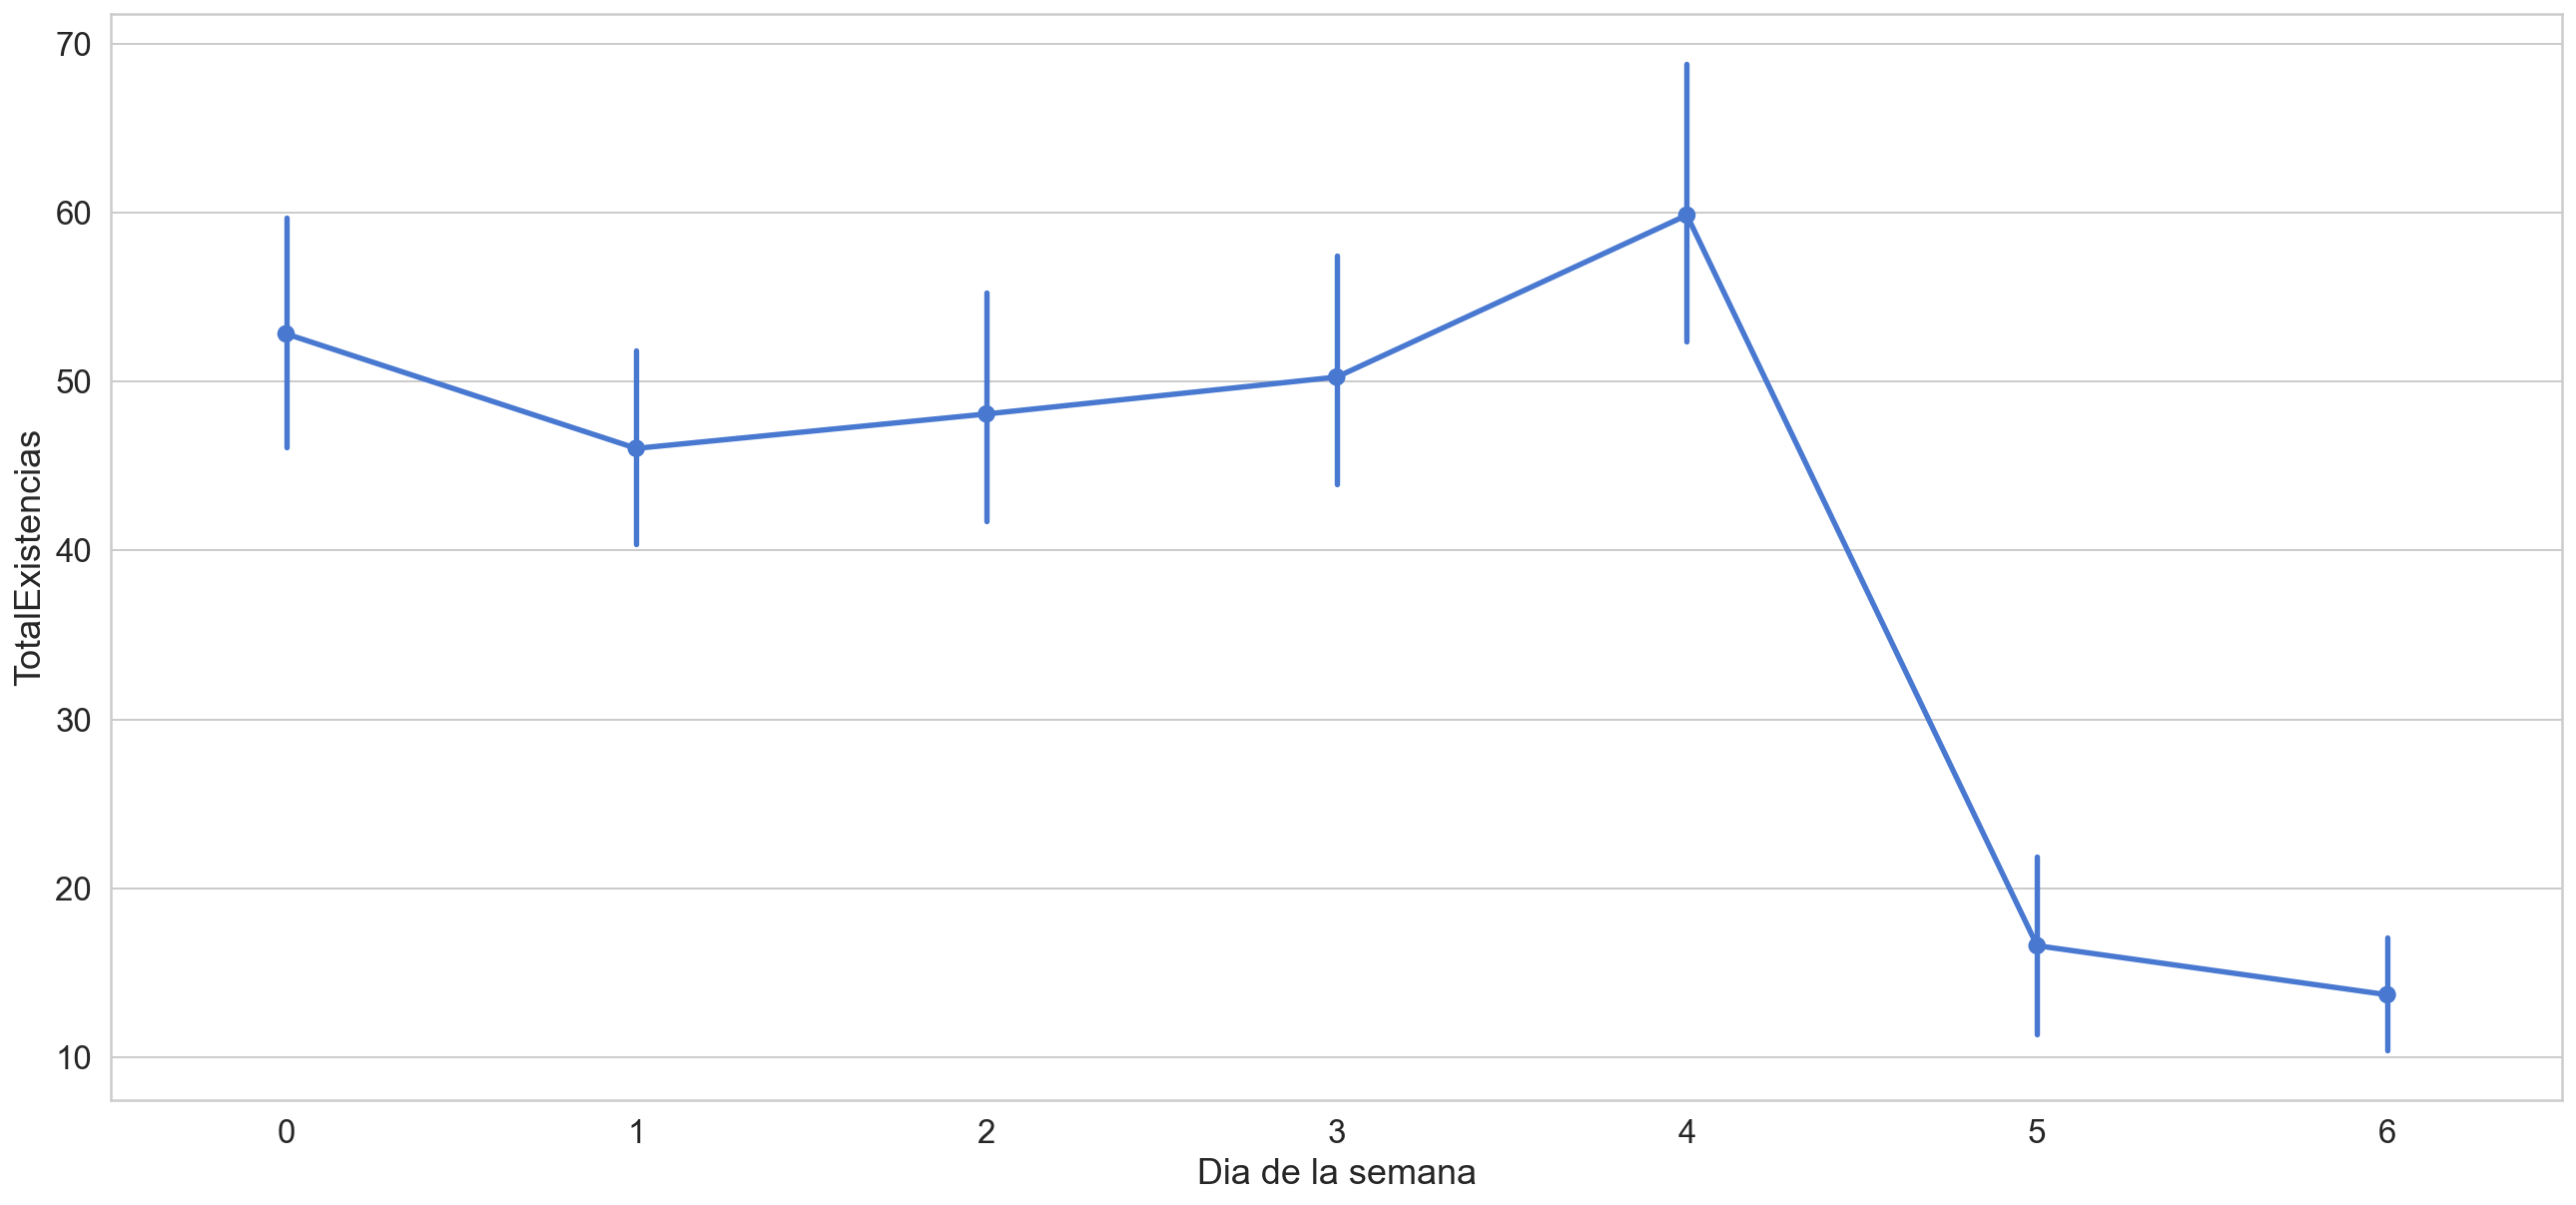

In [56]:
sns.pointplot(data=df, x='Dia de la semana', y='TotalExistencias')

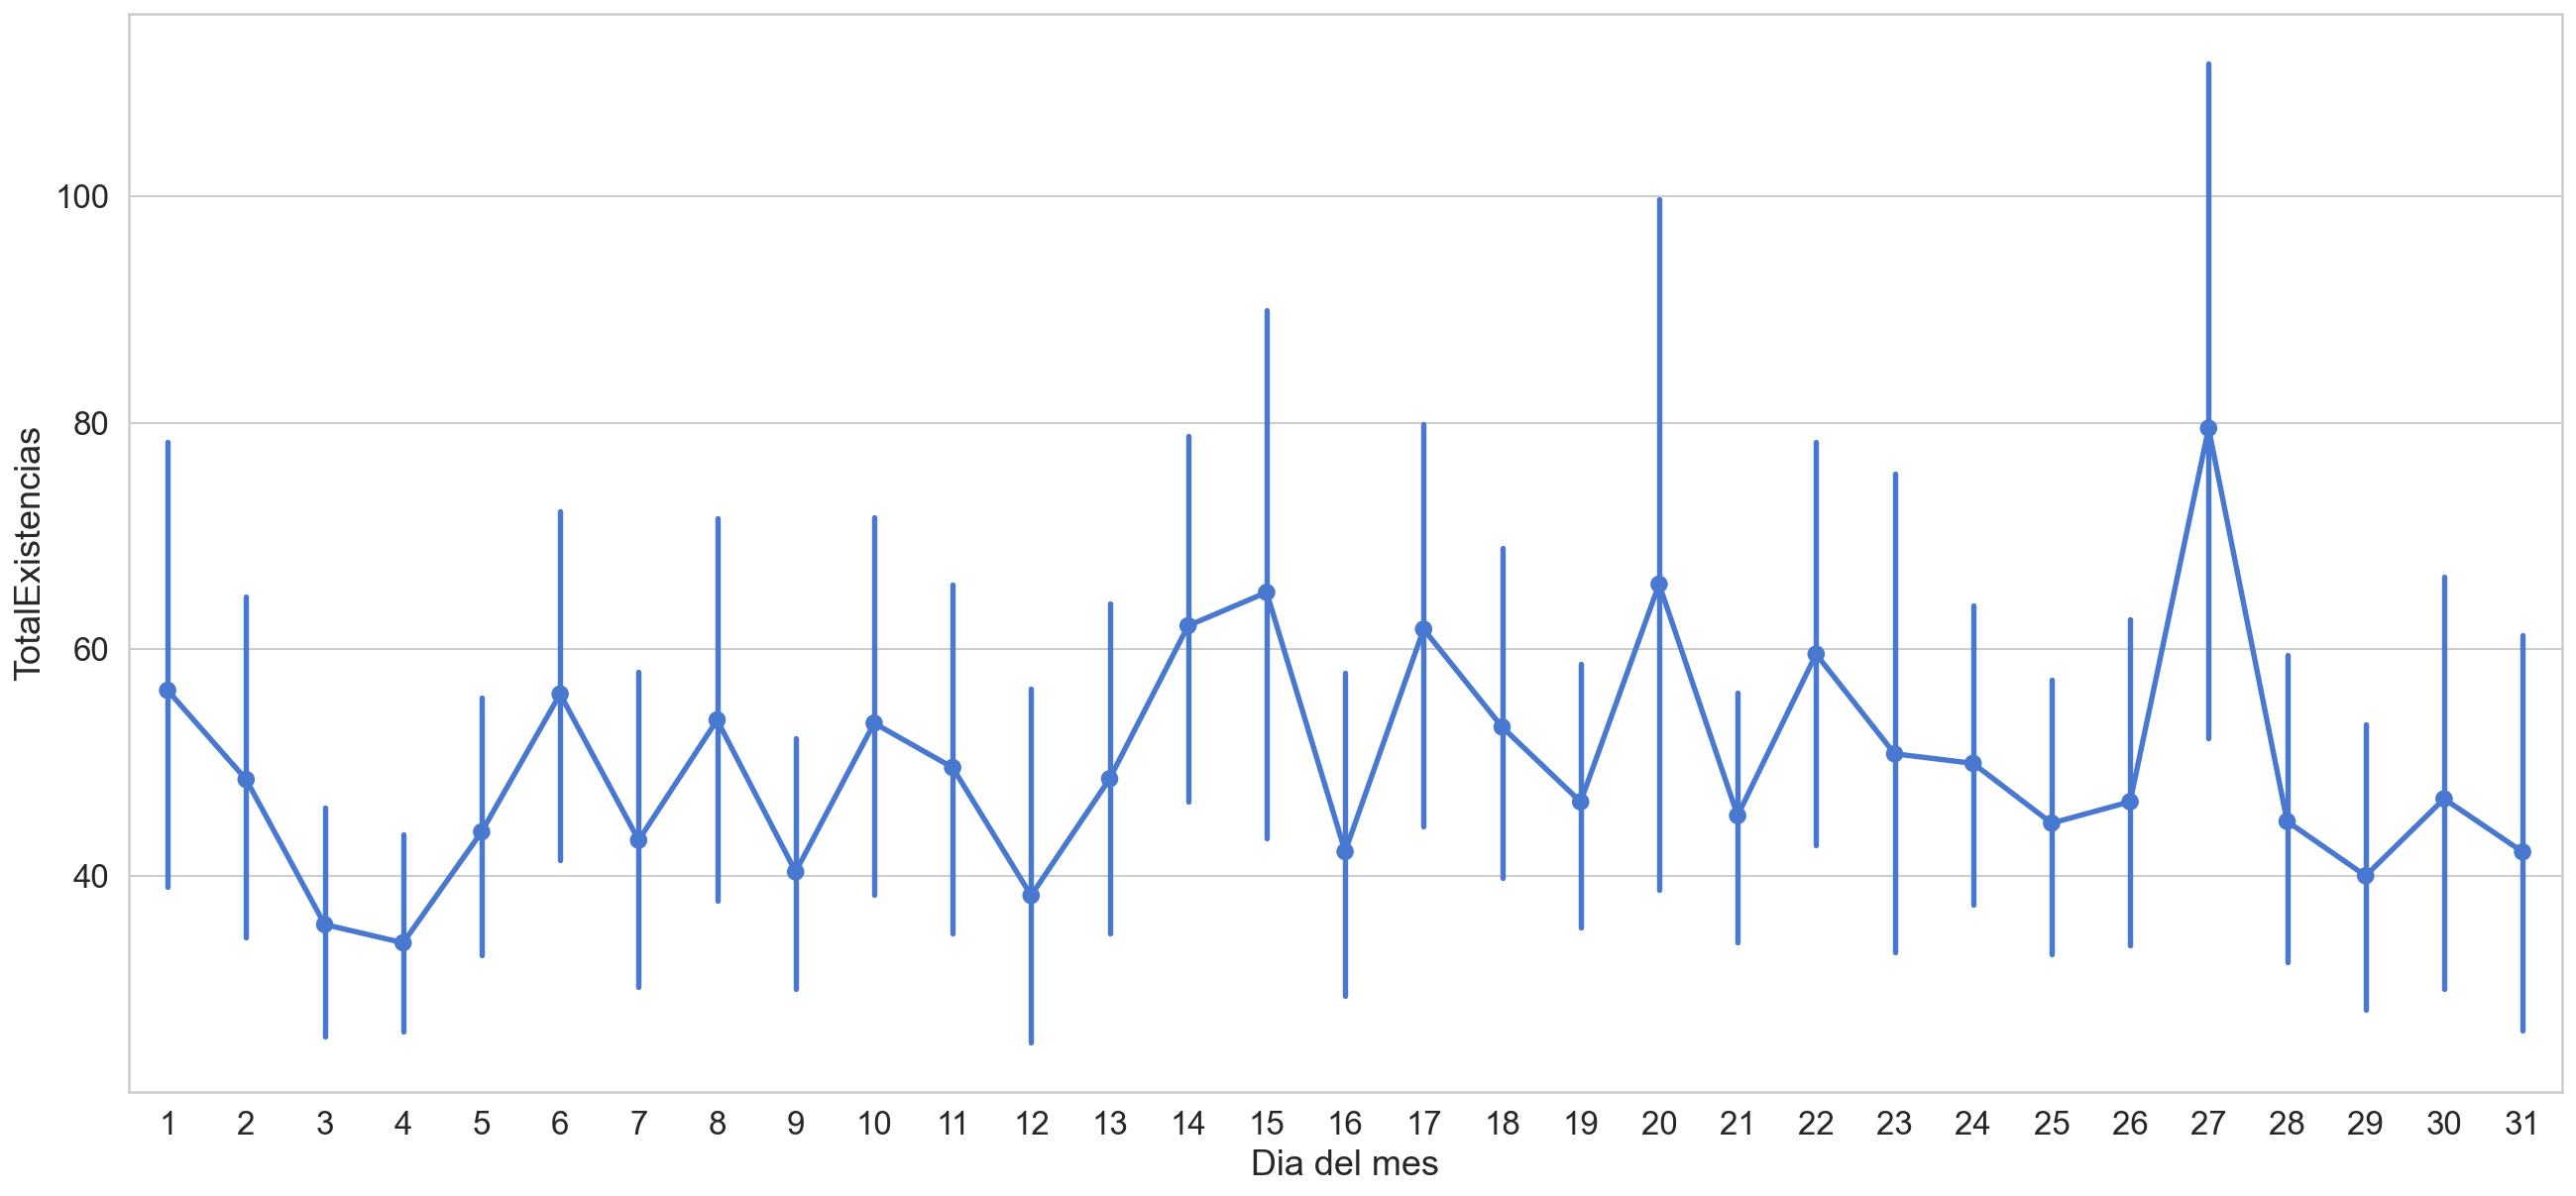

In [57]:
sns.pointplot(data=df, x='Dia del mes', y='TotalExistencias')

In [58]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size] , df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(905, 4) (101, 4)


In [59]:
from sklearn.preprocessing import RobustScaler
testfuturo = df2
#f_columns = ['caracteristicassincontarTotalExistencias']

#f_transformer = RobustScaler()  #por si hubiera más características en la tabla
cnt_transformer = RobustScaler()

#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['TotalExistencias']])

#train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy()) #transformamos el resto de características
train['TotalExistencias'] = cnt_transformer.transform(train[['TotalExistencias']])

#test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy()) #transformamos el resto de características
test['TotalExistencias'] = cnt_transformer.transform(test[['TotalExistencias']])
testfuturo['TotalExistencias'] = cnt_transformer.transform(df2[['TotalExistencias']])

C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Daniel\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [60]:
train_labels = train['TotalExistencias']
test_labels = test['TotalExistencias']
test_futuro_labels = testfuturo['TotalExistencias']

In [61]:
train.drop(columns=['TotalExistencias'],inplace=True)
test.drop(columns=['TotalExistencias'],inplace=True)
testfuturo.drop(columns=['TotalExistencias'],inplace=True)

C:\Users\Daniel\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Tenemos que transformar los datos en trozos de series temporales

In [62]:
TIME_STEPS = 10

X_train, y_train = create_dataset(train,train_labels,time_steps=TIME_STEPS)
X_test, y_test = create_dataset(test,test_labels,time_steps=TIME_STEPS)

In [63]:
X_test_futuro, y_test_futuro = create_dataset(testfuturo, test_futuro_labels,time_steps=TIME_STEPS)

In [64]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(895, 10, 3) (895,)
(91, 10, 3) (91,)


In [65]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

### Desarrollamos el modelo

In [66]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1],X_train.shape[2])  #30 y 4
        )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1)) #la salida es 1 número

In [67]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [68]:
#NO QUEREMOS MEZCLARLO PORQUE EL TS DEPENDE DEL ORDEN
history = model.fit(
    X_train,y_train,
    epochs=65,
    batch_size=24,  
    validation_split=0.1,
    shuffle=False)

Train on 805 samples, validate on 90 samples
Epoch 1/65
805/805 [==============================] - 3s 4ms/sample - loss: 1.1656 - val_loss: 0.6808
Epoch 2/65
805/805 [==============================] - 0s 223us/sample - loss: 1.2276 - val_loss: 0.5049
Epoch 3/65
805/805 [==============================] - 0s 222us/sample - loss: 1.1584 - val_loss: 0.6402
Epoch 4/65
805/805 [==============================] - 0s 219us/sample - loss: 1.1600 - val_loss: 0.8207
Epoch 5/65
805/805 [==============================] - 0s 221us/sample - loss: 1.2362 - val_loss: 0.9551
Epoch 6/65
805/805 [==============================] - 0s 219us/sample - loss: 1.2463 - val_loss: 0.8306
Epoch 7/65
805/805 [==============================] - 0s 221us/sample - loss: 1.1928 - val_loss: 0.7056
Epoch 8/65
805/805 [==============================] - 0s 219us/sample - loss: 1.1268 - val_loss: 0.6875
Epoch 9/65
805/805 [==============================] - 0s 218us/sample - loss: 1.1580 - val_loss: 0.6757
Epoch 10/65
805/805 [

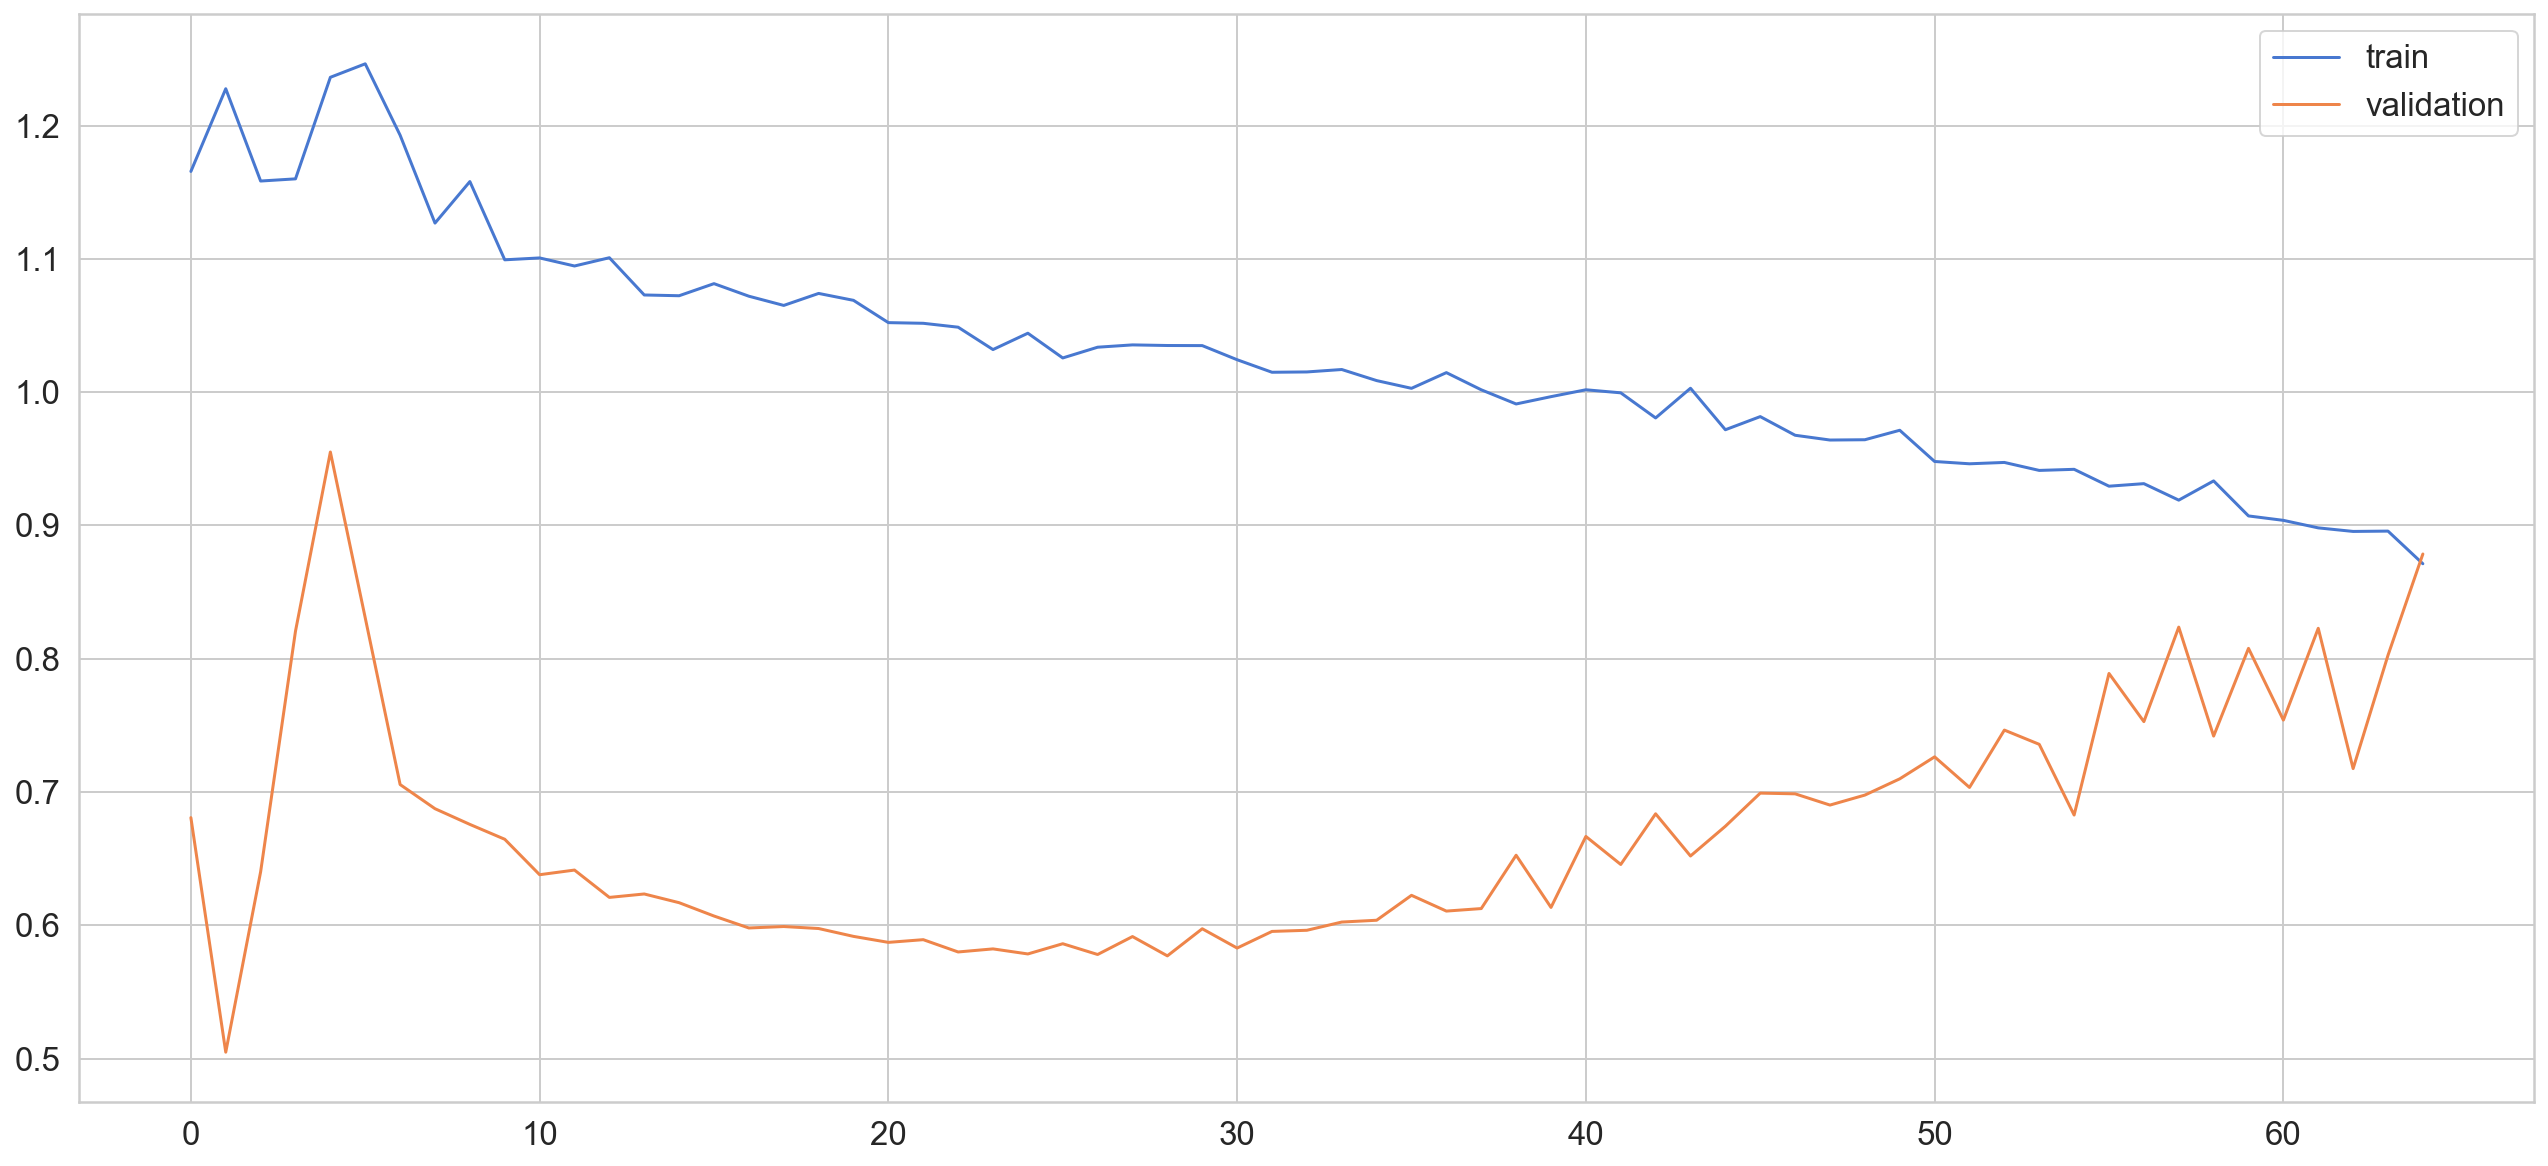

In [69]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [70]:
y_pred = model.predict(X_test)

In [71]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

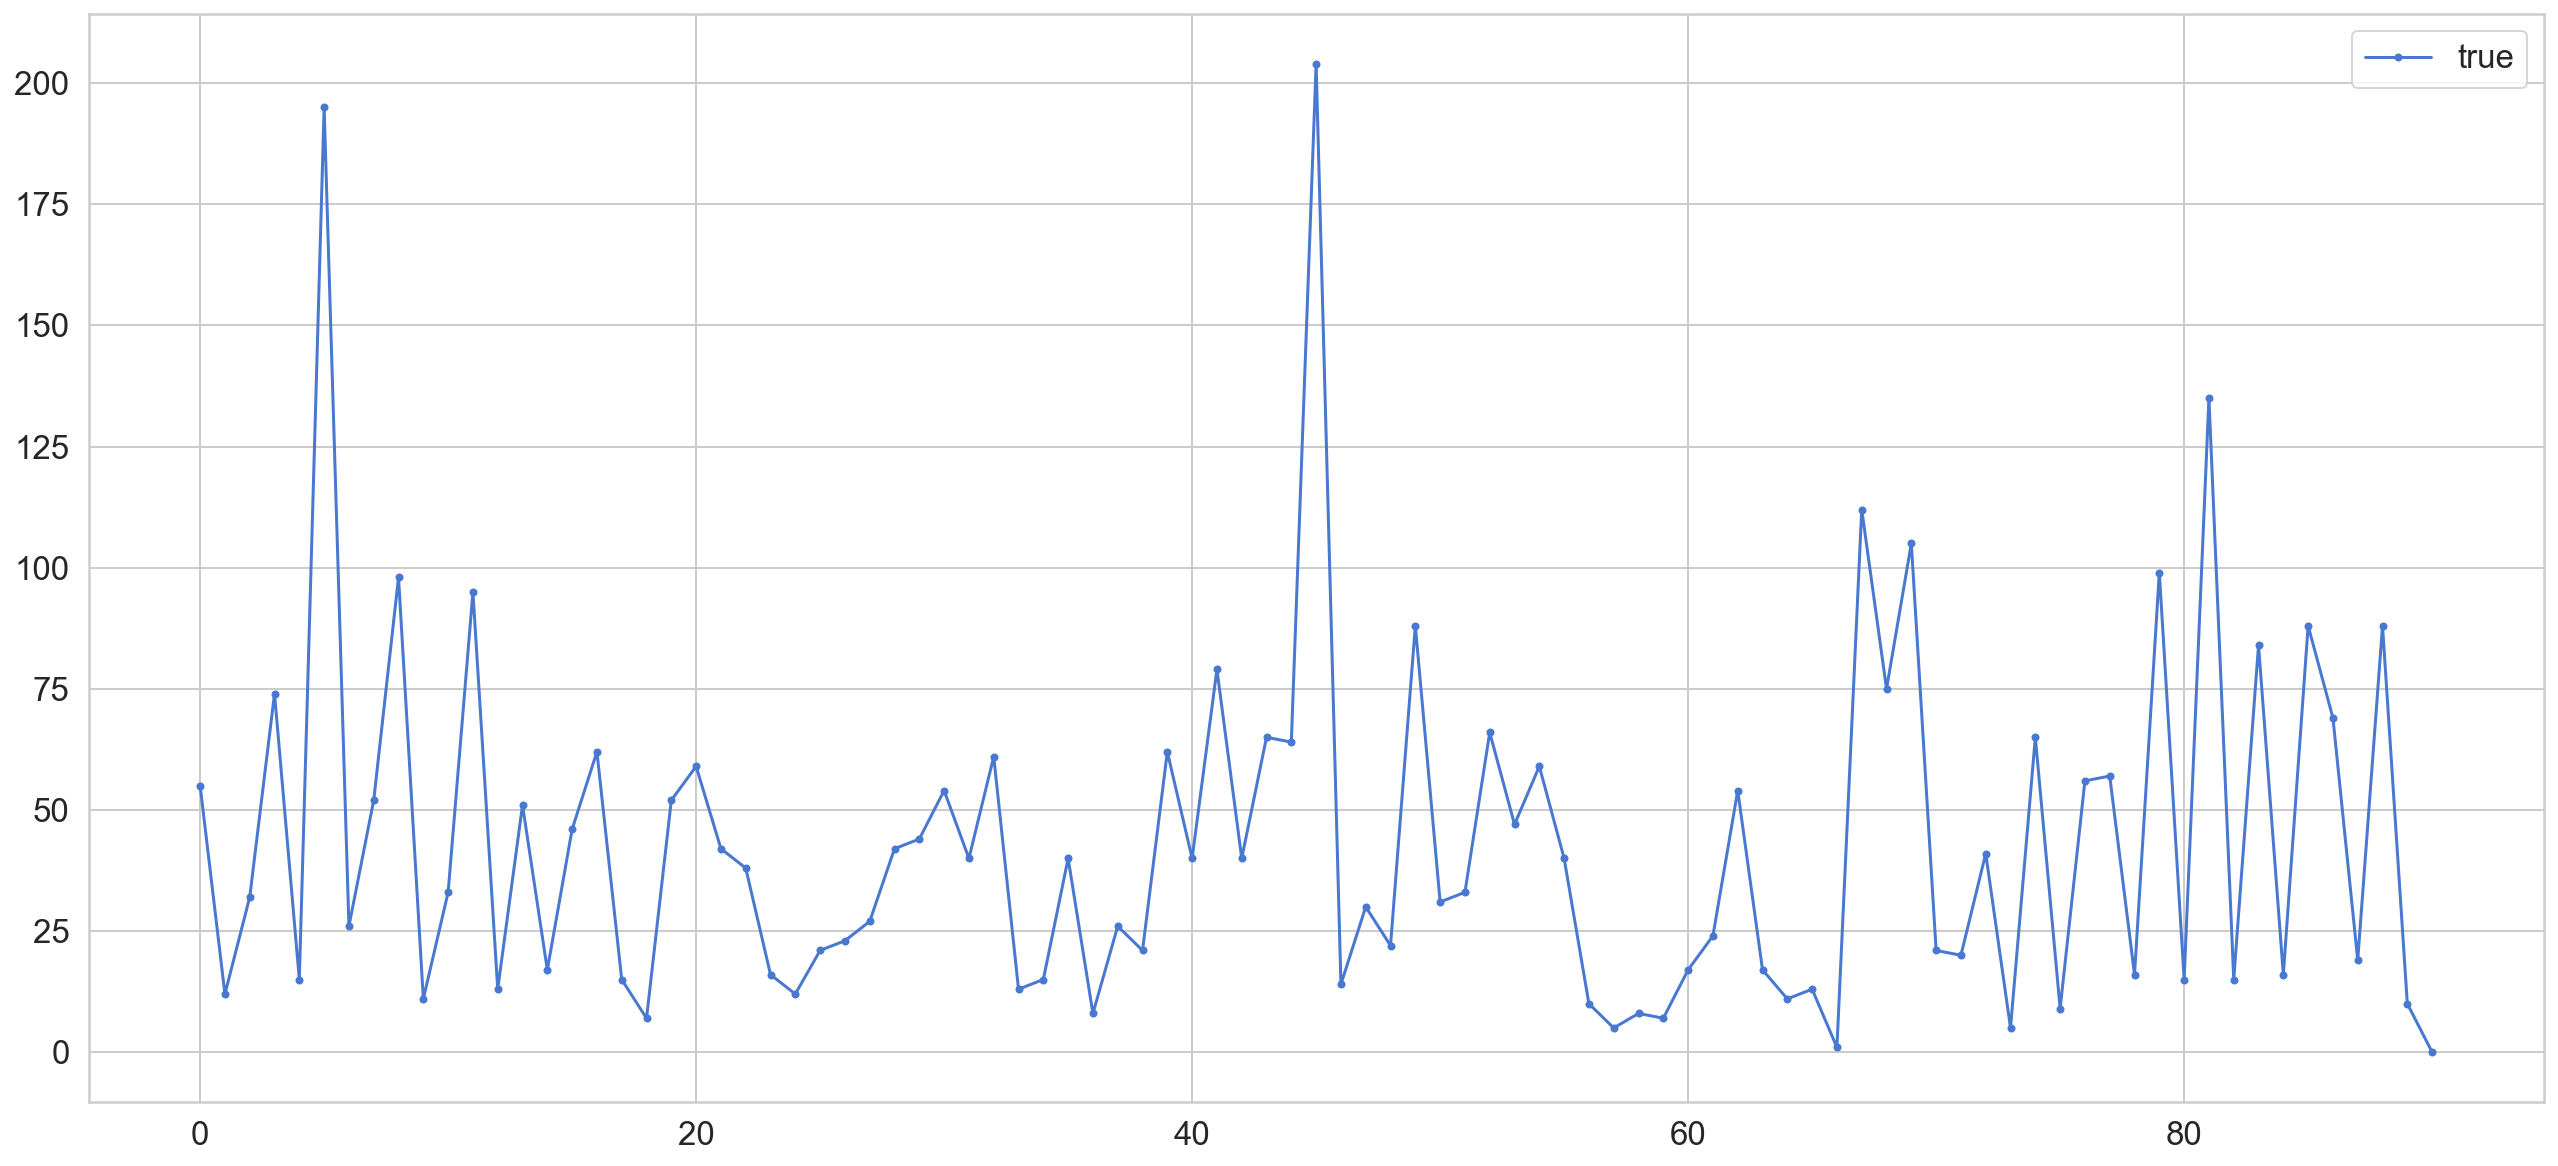

In [72]:
plt.plot(y_test_inv.flatten(),marker='.',label='true')
plt.legend();

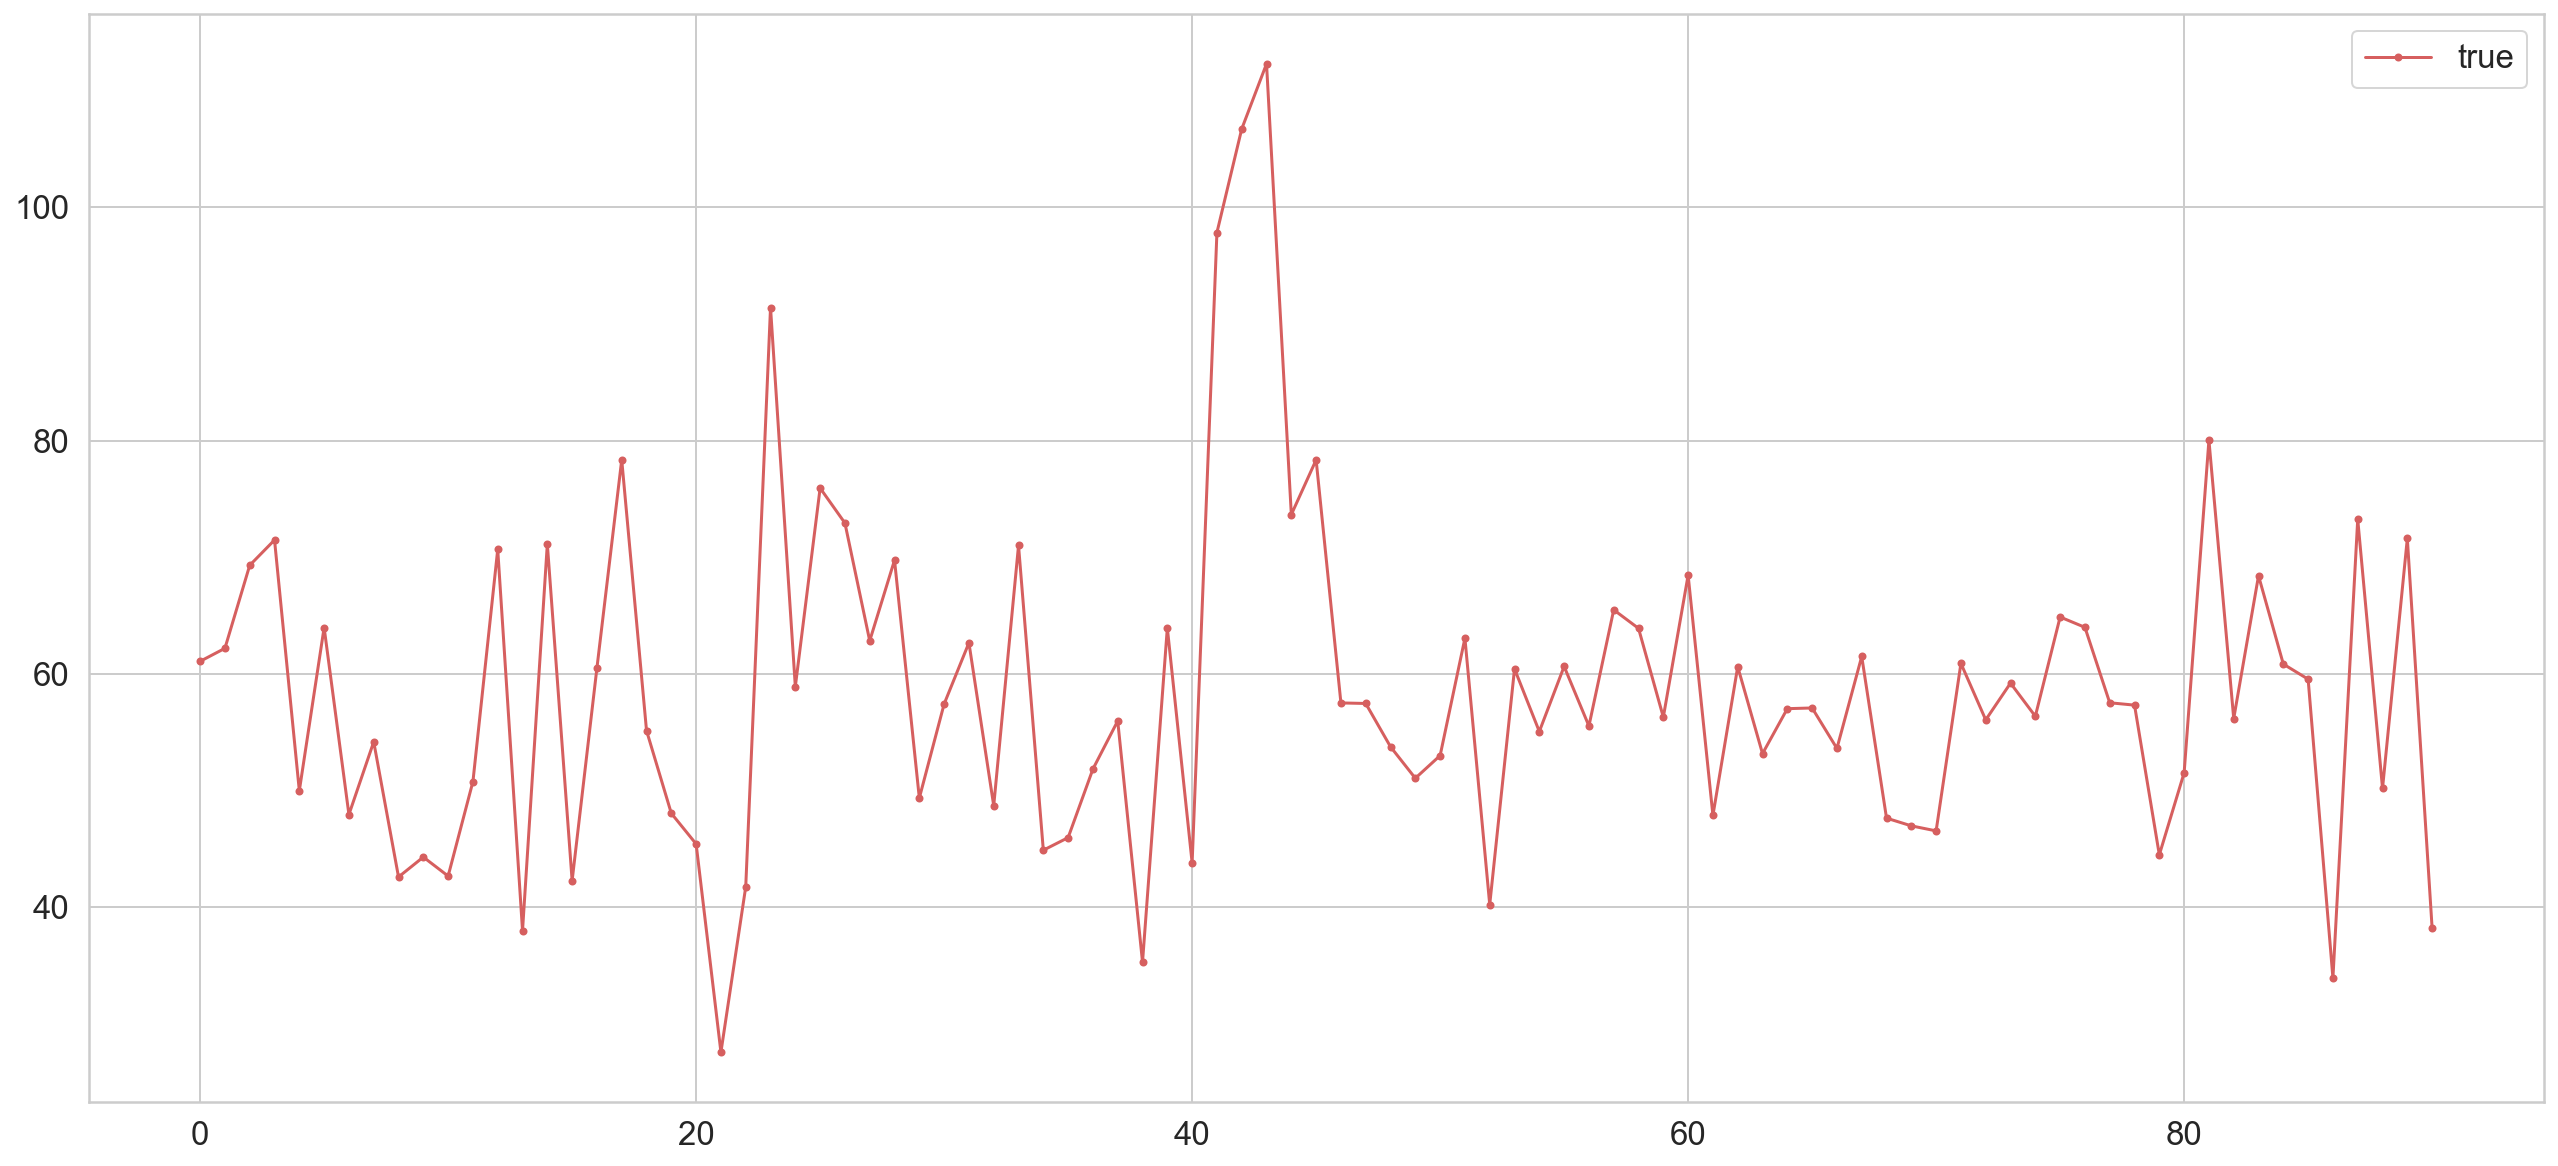

In [73]:
plt.plot(y_pred_inv.flatten(),'r',marker='.',label='true')
plt.legend();

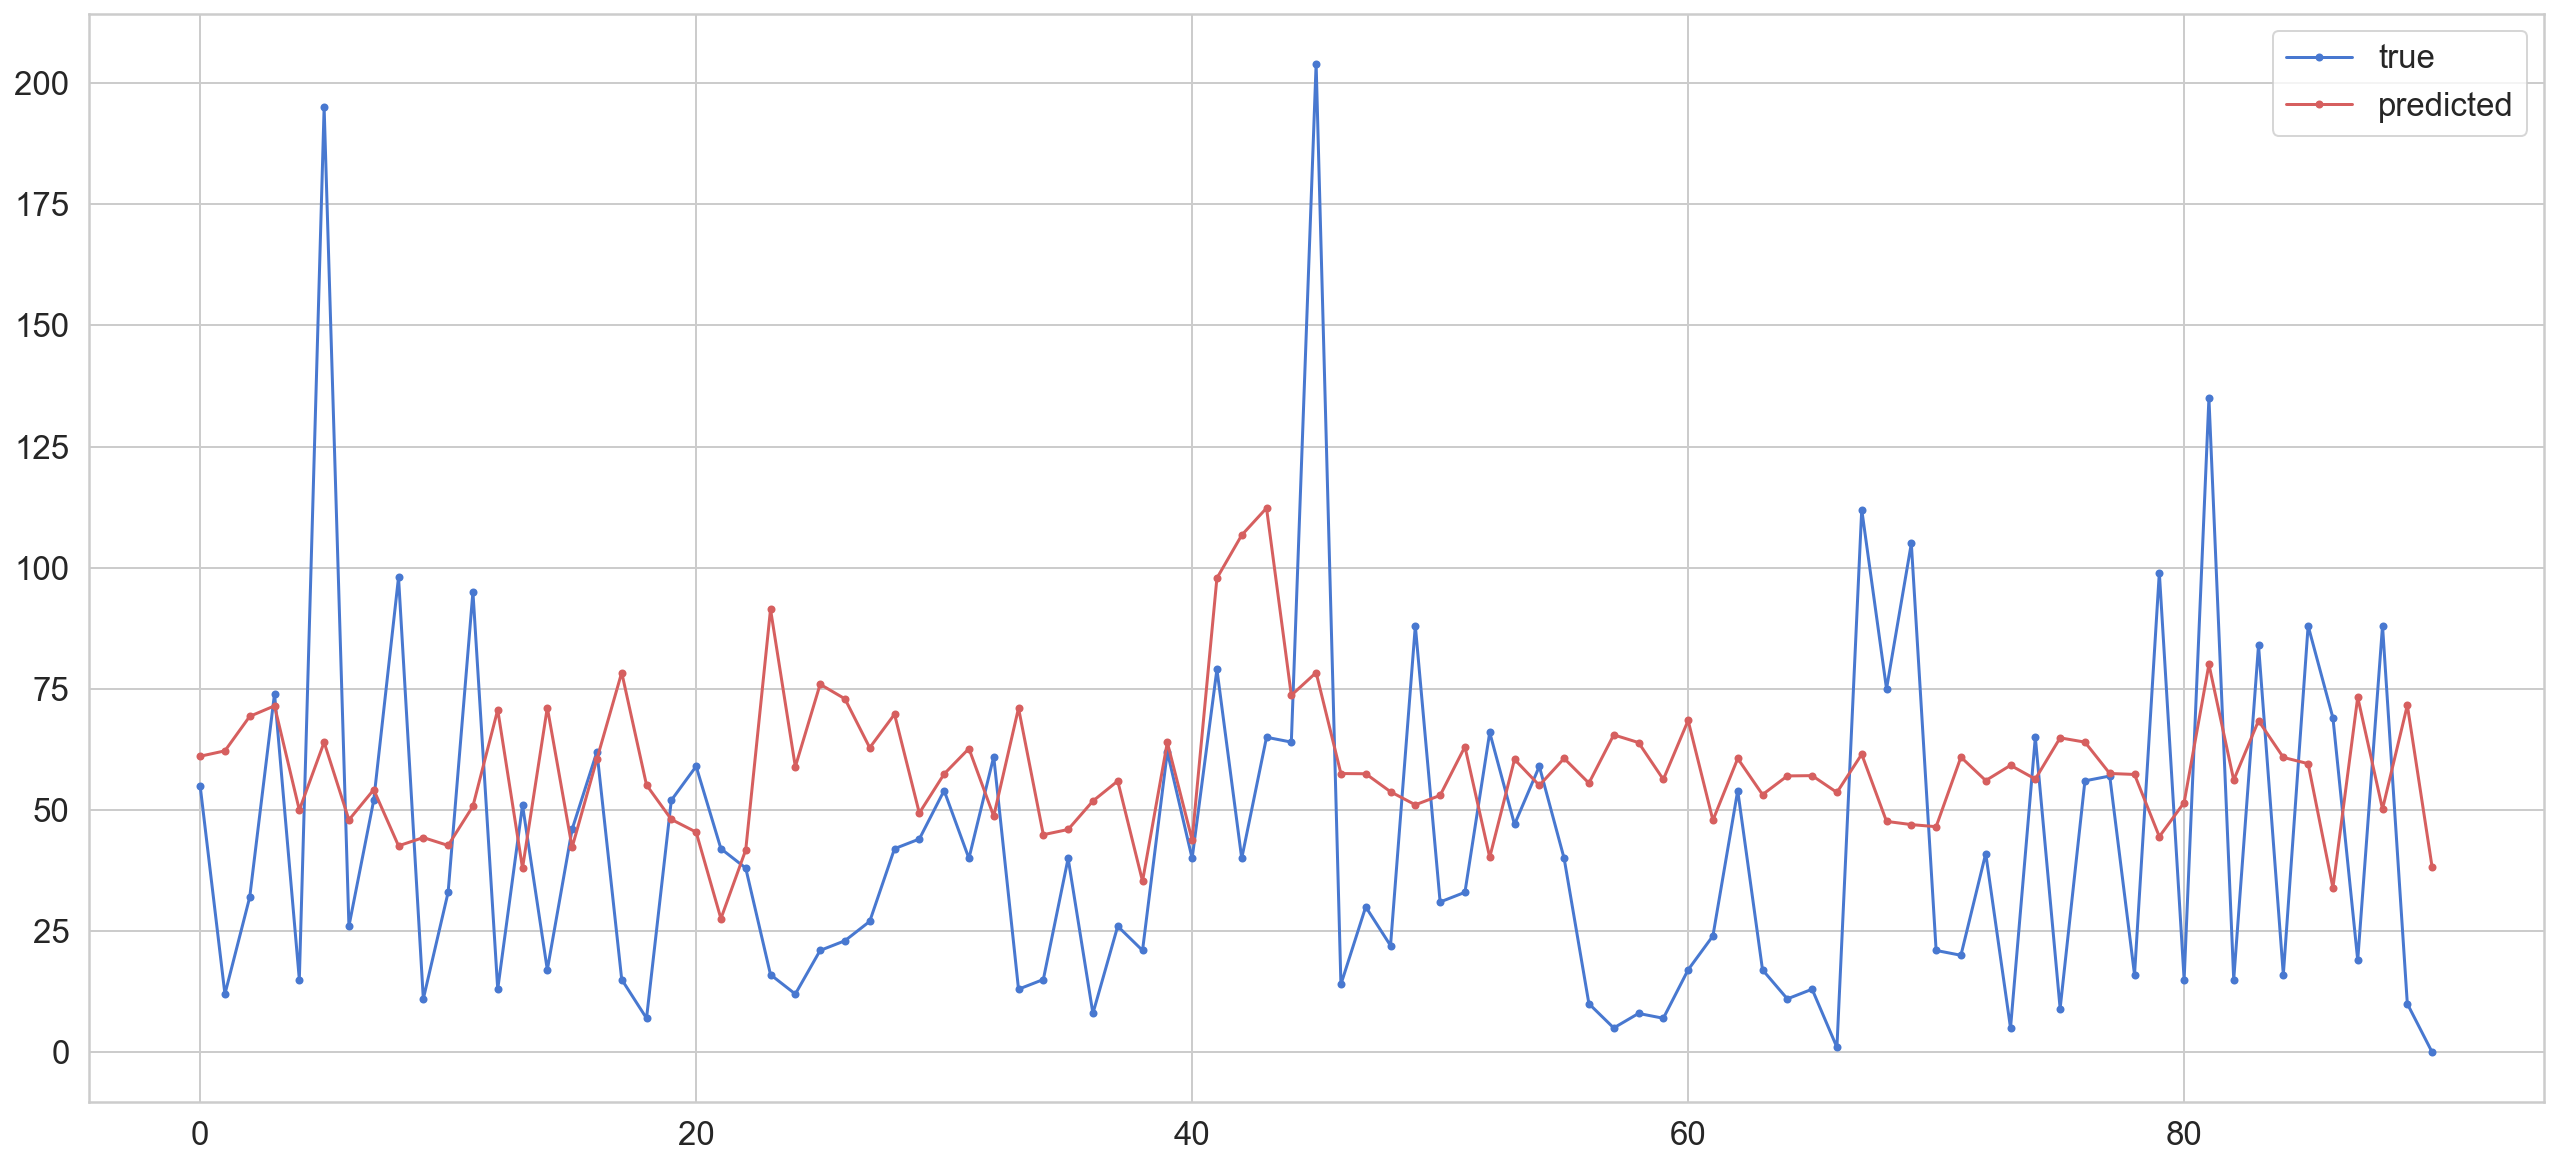

In [74]:
plt.plot(y_test_inv.flatten(),marker='.',label='true')
plt.plot(y_pred_inv.flatten(),'r', marker= '.',label='predicted')
plt.legend();

In [75]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 0.789


In [76]:
mse = mean_squared_error(y_test, y_pred)
print('MSE: %.3f' % mse)

MSE: 0.623


In [77]:
y_pred = model.predict(X_test_futuro)

In [78]:
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

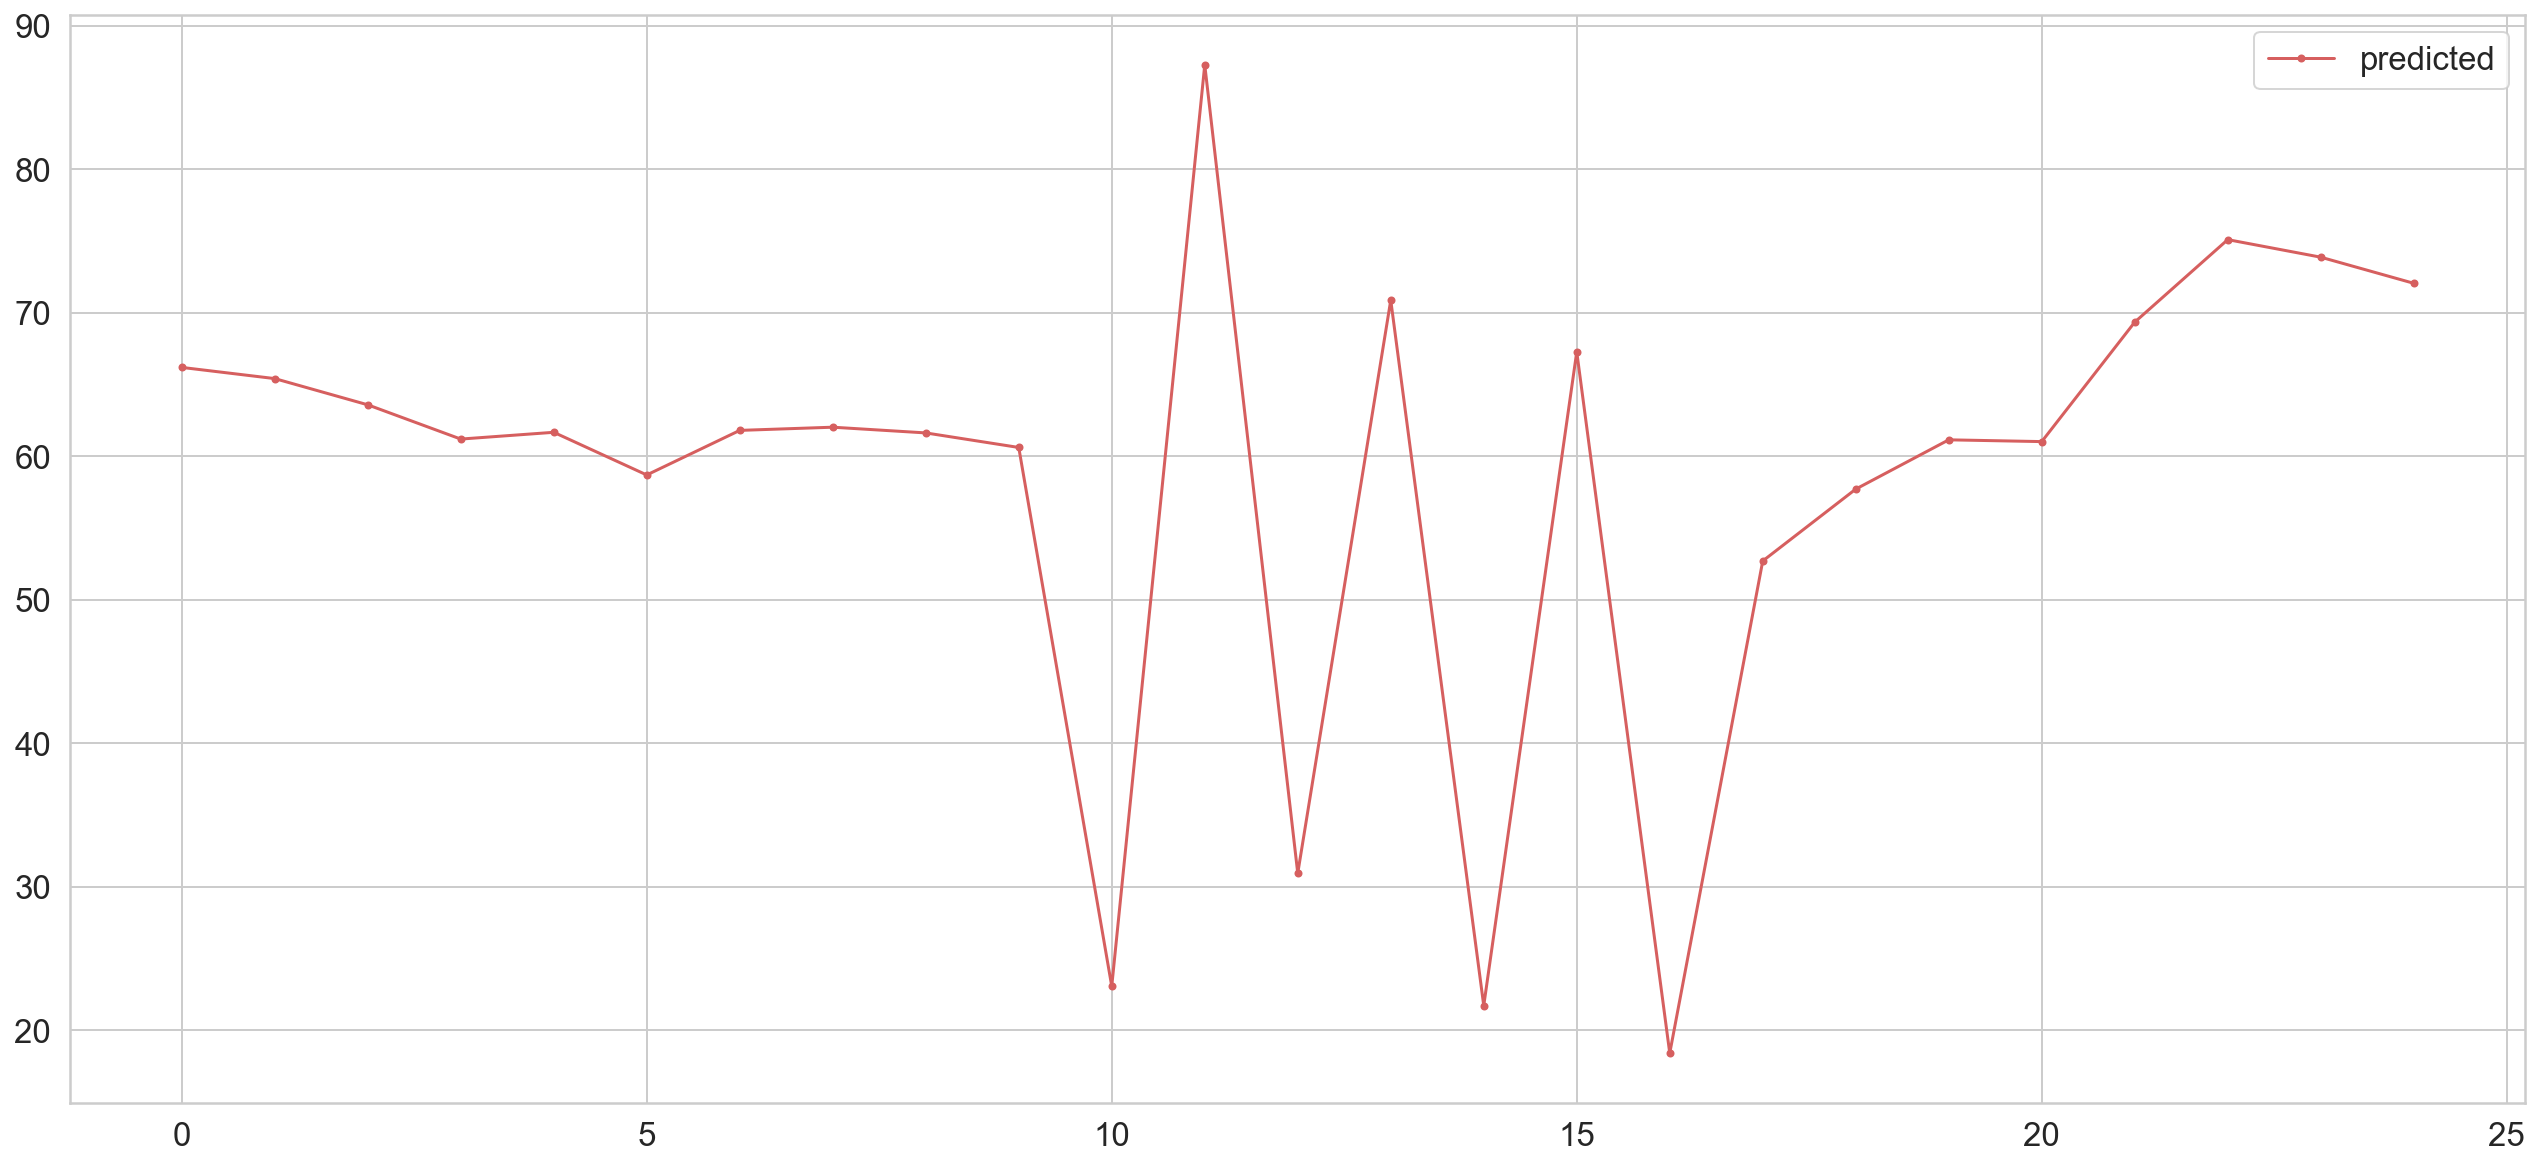

In [79]:
plt.plot(y_pred_inv.flatten(),'r', marker= '.',label='predicted')
plt.legend();

In [80]:
total_pred_inv = np.concatenate((y_test_inv.flatten(), y_pred_inv.flatten()))

In [81]:
total_pred_inv_index = np.arange(len(total_pred_inv))

In [82]:
total_pred_df = pd.DataFrame(data=total_pred_inv,index=total_pred_inv_index, columns=['True'])

In [83]:
y_pred_inv = y_pred_inv.flatten()

In [84]:
y_pred_inv_index = total_pred_inv_index[-len(y_pred_inv):]

In [85]:
y_pred_inv_df = pd.DataFrame(data=y_pred_inv,index=y_pred_inv_index,columns=['Forecast'])

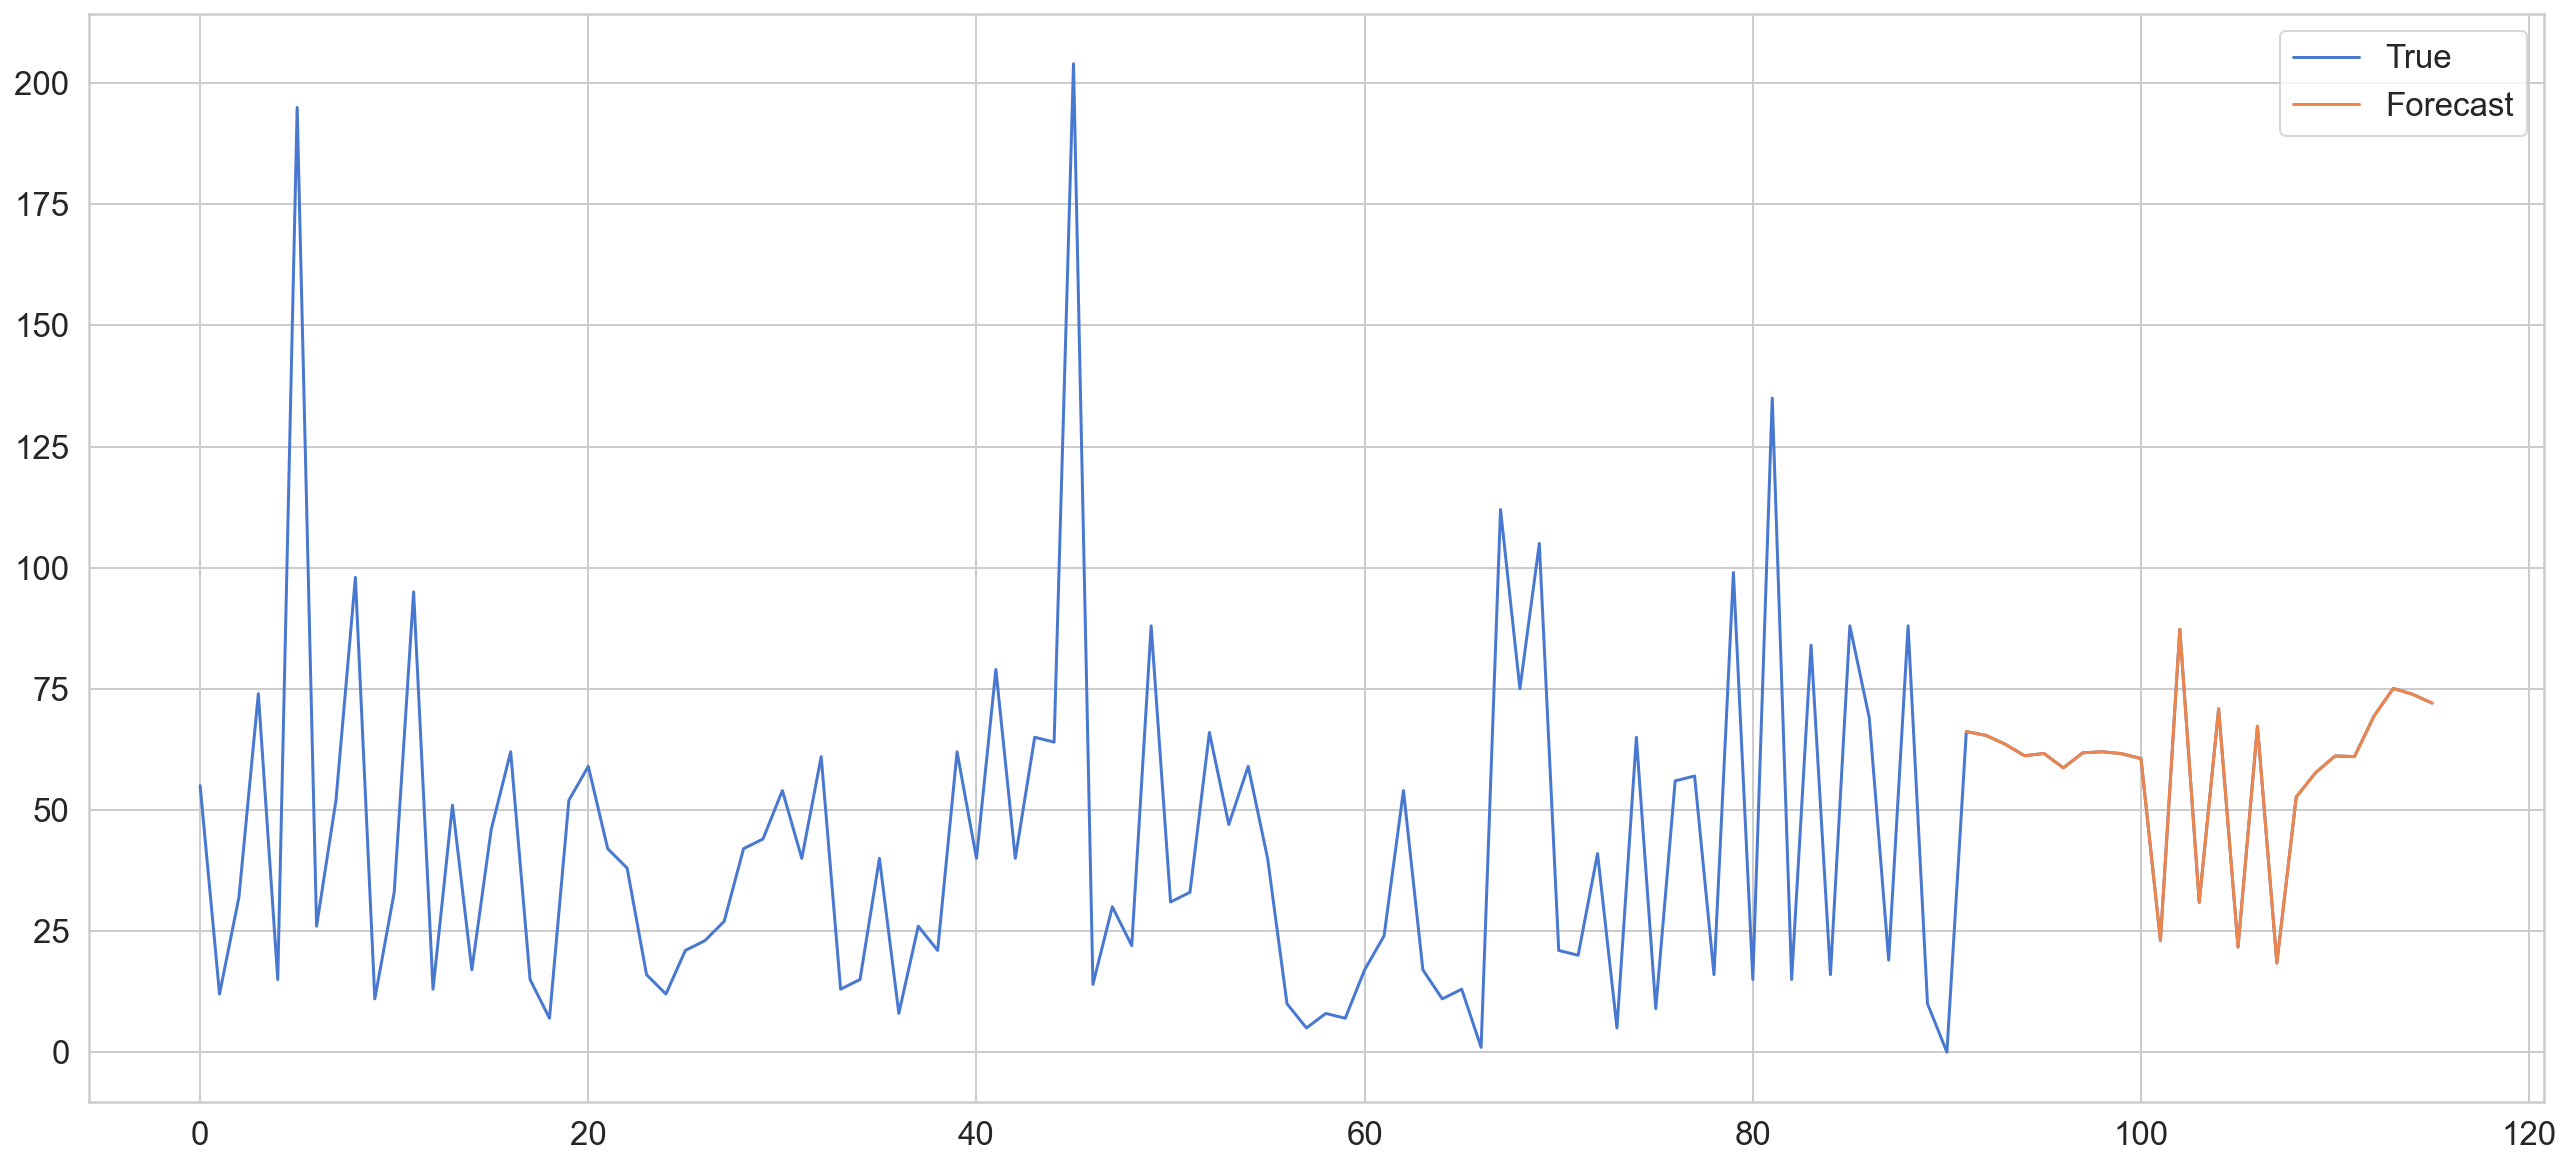

In [86]:
ax = total_pred_df.plot()
y_pred_inv_df.plot(ax=ax)